# Preprocessing
Process in batch, use signal energy

In [1]:
import numpy as np
import collections
import os
import argparse

import datetime as dt
import random
import scipy.io as spio
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

C:\nxt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class EEGRecord:
    def __init__(self):
        self.ictal = False
        self.subsz = False
        self.id = 0
        self.filehandle = []
        self.isCorrupt = False
        self.filepath = "None"
        self.se_data = "None" #h5py.File("")
        self.plv_data = "None" #h5py.File("")
        self.cfc_data = "None" #h5py.File("")
        self.raw_data = "None" #h5py.File("")
        self.subclin_onsets = []
        self.subclin_offsets = []
        self.clin_onsets = []
        self.clin_offsets = []      
        self.used = 0
        self.fs = 0
        
    def sz_length(self):
        return int(self.clin_offsets[0]) - int(self.clin_onsets[0])

    def length(self):
        return self.n_samples
    
    def get_n_sz_samps(self):
        n_sz_samps = 0
        for idx in range(len(self.clin_onsets)):
            n_sz_samps += self.clin_offsets[idx] - self.clin_onsets[idx]
        for idx in range(len(self.subclin_onsets)):
            n_sz_samps += self.subclin_offsets[idx] - self.subclin_onsets[idx]
        return n_sz_samps 

    def get_sz_samp_idxs(self):
        idxs = []
        for idx in range(len(self.clin_onsets)):
            idxs  += list(range ( int(self.clin_onsets[idx]), int(self.clin_offsets[idx])))
        for idx in range(len(self.subclin_onsets)):
            idxs  += list(range(int(self.subclin_onsets[idx]), int(self.subclin_offsets[idx]))) 
        if not idxs:
            print("Warning, ID ", self.id, " contains no seizure samples")
        return idxs

    def get_sz_eeg_idxs(self):
        idxs = []
        for idx in range(len(self.clin_onsets)):
            idxs  += list(range ( int(self.clin_onsets[idx]*self.feature_ds_rate), int(self.clin_offsets[idx]*self.feature_ds_rate)))
        for idx in range(len(self.subclin_onsets)):
            idxs  += list(range(int(self.subclin_onsets[idx]*self.feature_ds_rate), int(self.subclin_offsets[idx]*self.feature_ds_rate)))
        if not idxs:
            print("Warning, ID ", self.id, " contains no seizure samples")
        return idxs        

    def get_sz_samps(self):
        idxs = self.get_sz_samp_idxs()
        if (len(idxs) == 0):
            print("Warning, ID ", self.id, " contains no seizure samples")
            data = []
        else:
            data = self.get_data()
            data = data[idxs,:]
        return data

    def get_labels(self):
        labels = np.ones(self.n_samples)
        for idx in range(len(self.clin_onsets)):
            labels[ int(self.clin_onsets[idx]) : int(self.clin_offsets[idx]) ] = -1
        for idx in range(len(self.subclin_onsets)):
            labels[ int(self.subclin_onsets[idx]) : int(self.subclin_offsets[idx]) ] = 0      
        return labels
 
    # ======================================================================
def check_corrupt (eeg_db, backup_dir='/BACKUP/'):
    ## first file in current dir (with full path)
    fpath = eeg_db.filepath;
    fname = os.path.basename(fpath)
    bkup_fpath = os.path.dirname(fpath) + backup_dir ## directory of directory of file

    src = bkup_fpath + fname
    dst = fpath
    hash_src = sha_checksum(src)
    hash_dst = sha_checksum(dst)
    # hash_src = hashlib.md5(open(src,'rb').read()).hexdigest()
    # hash_dst = hashlib.md5(open(dst,'rb').read()).hexdigest()

    if (hash_dst != hash_src):
        print('WARNING: DB ', fname , 'is corrupt...')
        print('Golden:  ',  hash_src)
        print('Current: ',  hash_dst)
        print('replacing: ')
        print(src)
        print(dst)
        copyfile(src, dst)


def sha_checksum(filename, block_size=65536):
    # t = time.time() # sha1 faster than md5/sha256
    sha1 = hashlib.sha1()
    with open(filename, 'rb') as f:
        for block in iter(lambda: f.read(block_size), b''):
            sha1.update(block)
    # print "Elapsed: ", time.time() - t
    return sha1.hexdigest()

In [3]:
class xt_subject:
    def __init__(self):
        #
        self.dir_in = ""
        self.dir_ou = ""
        #
        self.n_sz_file = 0 # number
        self.list_sz_file = [] # list
        self.pos_sz_on = []  # position
        self.pos_sz_off = []
        #
        self.n_nonsz_file = 0
        self.list_nonsz_file = []
        #
        self.n_file = 165
        self.n_timestep = 256
        self.n_channel = 16
        #
        self.interictal_sample = 0
        self.ictal_sample = 0
        # 
        self.clip_len = 1
        self.list_file = []

In [4]:
# ======================================================
# Read the database and categorize no-seizure files
# and seizure files
# ======================================================
def xt_categorize_EUDB(subject, error_check):
    print('INFO: Load database')
    
    subject.n_nonsz_file = 0
    subject.n_sz_file = 0
    subject.list_nonsz_file = []
    subject.list_sz_file = []
    subject.pos_sz_on = []
    subject.pos_sz_off = []
    
    #
    for idx in subject.list_file:
        tmp_db = EEGRecord()

        # Preprocess index idx
        idx_str = str(idx)
        if idx < 10:
            idx_str = '00' + idx_str
        elif idx < 100:
            idx_str = '0' + idx_str
            
        mat_file_path = os.path.join(subject.dir_in, 'EDMSE_pat_FR_1096_' + idx_str + '.mat')
        #print('--- Debug: Open file ', mat_file_path)
        f = h5py.File(mat_file_path, 'r', libver='latest')

        tmp_db.id = int(f["record_idx"][0])
        tmp_db.filepath = mat_file_path
        tmp_db.fs = np.asscalar(f["Fs"][0])
        #tmp_db.raw_data = f["signal"]  # 921,600 rows x 16 cols
        #tmp_db.n_samples = tmp_db.raw_data[0]
        isSz = f["sample_sz_onset"][0]
        isSCSz = f["sample_scsz_onset"][0]
        
        # Store the index of seizure and non-seizure files
        if (isSz or isSCSz):
            subject.n_sz_file = subject.n_sz_file + 1
            subject.list_sz_file.append(idx)
        else:
            subject.n_nonsz_file = subject.n_nonsz_file + 1
            subject.list_nonsz_file.append(idx)
           
        #
        if(isSz):
            tmp_db.ictal = True
            tmp_db.clin_onsets = np.asscalar(f["sample_sz_onset"][0])
            tmp_db.clin_onsets = np.asscalar(f[tmp_db.clin_onsets][0])
            tmp_db.clin_offsets = np.asscalar(f["sample_sz_end"][0])
            tmp_db.clin_offsets = np.asscalar(f[tmp_db.clin_offsets][0])
            
            subject.pos_sz_on.append(tmp_db.clin_onsets)
            subject.pos_sz_off.append(tmp_db.clin_offsets)
        #    
        elif (isSCSz):
            tmp_db.subsz = True
            tmp_db.subclin_onsets = np.asscalar(f["sample_scsz_onset"][0])
            tmp_db.subclin_onsets = np.asscalar(f[tmp_db.subclin_onsets][0])
            tmp_db.subclin_offsets = np.asscalar(f["sample_scsz_end"][0])
            tmp_db.subclin_offsets = np.asscalar(f[tmp_db.subclin_offsets][0])
            
            subject.pos_sz_on.append(tmp_db.subclin_onsets)
            subject.pos_sz_off.append(tmp_db.subclin_offsets)
        #
        else:
            tmp_db.ictal = False
            subject.pos_sz_on.append(0)
            subject.pos_sz_off.append(0)
            
        print('--- Debug: id ictal subsz =', \
              tmp_db.id, tmp_db.ictal, tmp_db.subsz, \
                tmp_db.clin_onsets, tmp_db.clin_offsets, tmp_db.subclin_onsets, tmp_db.subclin_offsets)

        if (error_check):
            check_corrupt(tmp_db)

        f.flush()
        f.close()

# ===============================================
# Test function
# ===============================================
error_check = 0
patient = xt_subject()
patient.list_file = np.arange(1, 165)
patient.dir_in = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU'


xt_categorize_EUDB(patient, error_check)

INFO: Load database
--- Debug: id ictal subsz = 1 False False [] [] [] []
--- Debug: id ictal subsz = 2 False True [] [] 135168.25 144896.25
--- Debug: id ictal subsz = 3 False True [] [] 441088.25 449536.25
--- Debug: id ictal subsz = 4 False False [] [] [] []
--- Debug: id ictal subsz = 5 False True [] [] 276992.25 287488.25
--- Debug: id ictal subsz = 6 False False [] [] [] []
--- Debug: id ictal subsz = 7 False False [] [] [] []
--- Debug: id ictal subsz = 8 False True [] [] 276992.25 286464.25
--- Debug: id ictal subsz = 9 False False [] [] [] []
--- Debug: id ictal subsz = 10 False False [] [] [] []
--- Debug: id ictal subsz = 11 False False [] [] [] []
--- Debug: id ictal subsz = 12 False True [] [] 647424.25 649728.25
--- Debug: id ictal subsz = 13 False False [] [] [] []
--- Debug: id ictal subsz = 14 False False [] [] [] []
--- Debug: id ictal subsz = 15 False False [] [] [] []
--- Debug: id ictal subsz = 16 False False [] [] [] []
--- Debug: id ictal subsz = 17 False False [

--- Debug: id ictal subsz = 149 False False [] [] [] []
--- Debug: id ictal subsz = 150 False False [] [] [] []
--- Debug: id ictal subsz = 151 False False [] [] [] []
--- Debug: id ictal subsz = 152 False False [] [] [] []
--- Debug: id ictal subsz = 153 False False [] [] [] []
--- Debug: id ictal subsz = 154 False False [] [] [] []
--- Debug: id ictal subsz = 155 False False [] [] [] []
--- Debug: id ictal subsz = 156 False False [] [] [] []
--- Debug: id ictal subsz = 157 False False [] [] [] []
--- Debug: id ictal subsz = 158 False False [] [] [] []
--- Debug: id ictal subsz = 159 False False [] [] [] []
--- Debug: id ictal subsz = 160 False False [] [] [] []
--- Debug: id ictal subsz = 161 False False [] [] [] []
--- Debug: id ictal subsz = 162 False False [] [] [] []
--- Debug: id ictal subsz = 163 False False [] [] [] []
--- Debug: id ictal subsz = 164 False False [] [] [] []


# METHOD 3

In [75]:
# ===================================================
# Make 64-s clip corresponding to 1 batch
# ===================================================
def xt_clip_gen (subject, file_sel, add_len_in_sec):    
    
    if file_sel == 'ictal':
        file_ou_x = os.path.join(subject.dir_ou, 'x_ic_it')
        file_ou_y = os.path.join(subject.dir_ou, 'y_ic_it')
    elif file_sel == 'interictal':
        file_ou_x = os.path.join(subject.dir_ou, 'x_it')
        file_ou_y = os.path.join(subject.dir_ou, 'y_it')        
    
    fo_x = open(file_ou_x, 'w+')
    fo_x.close()
    fo_y = open(file_ou_y, 'w+')
    fo_y.close()
    N = subject.list_file
    
    n_sum_ones = 0
    n_sum_zeros = 0
        
    # Make 64-s clip
    n_sz = 0
    for idx in N:
        # Preprocess index idx
        idx_str = str(idx)                
        #
        tmp_db = EEGRecord()
        if idx < 10:
            idx_str = '00' + idx_str
        elif idx < 100:
            idx_str = '0' + idx_str

        mat_file_path = os.path.join(subject.dir_in, 'EDMSE_pat_FR_1096_' + idx_str + '.mat')
        print('--- Debug: Open file ', mat_file_path)
        f = h5py.File(mat_file_path, 'r', libver='latest')

        tmp_db.raw_data = np.asarray(f["signal"])  # 921,600 rows x 16 cols
        tmp_db.raw_data = tmp_db.raw_data.T

        n_step = tmp_db.raw_data.shape[0]
        
        # Ictal
        if file_sel == 'ictal':
            sz_len_in_sec = int((subject.pos_sz_off[idx-1] - subject.pos_sz_on[idx-1]) / subject.n_timestep)
            pos_sz_on = int(subject.pos_sz_on[idx-1])
            pos_sz_off = pos_sz_on + sz_len_in_sec * subject.n_timestep
                        
            # For debug only
            n_sz = n_sz + sz_len_in_sec
            
            #
            if pos_sz_on > 0 and pos_sz_off > 0:
                print('------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec =', \
                      n_step, pos_sz_on, pos_sz_off, sz_len_in_sec)
                
                add_len = add_len_in_sec * subject.n_timestep
                new_pos_sz_on = pos_sz_on - add_len
                new_pos_sz_off = new_pos_sz_on + 2 * add_len
                
                while new_pos_sz_on < pos_sz_off - add_len:
                    #print('------ Debug: new_pos_sz_on, new_pos_sz_off, pos_sz_on, pos_sz_off =', \
                    #      new_pos_sz_on, new_pos_sz_off, pos_sz_on, pos_sz_off)
                    # X
                    with open(file_ou_x, 'a') as fo_x:
                        np.savetxt(fo_x, tmp_db.raw_data[new_pos_sz_on:new_pos_sz_off, :], delimiter= " ", fmt = '%.2f')
                        
                    # y
                    if new_pos_sz_on < pos_sz_on and new_pos_sz_off < pos_sz_off:
                        n_sec_y0 = int((pos_sz_on - new_pos_sz_on)/subject.n_timestep)
                        n_sec_y1 = int((new_pos_sz_off - pos_sz_on)/subject.n_timestep)
                        #print('------ Debug: n_sec_y0, n_sec_y1 =', n_sec_y0, n_sec_y1)
                        y0 = np.zeros((n_sec_y0, 1))
                        y1 = np.ones((n_sec_y1, 1))
                        y = np.concatenate((y0, y1), axis=0)
                        
                    elif new_pos_sz_on > pos_sz_on and new_pos_sz_off < pos_sz_off:
                        n_sec_y0 = 2 * add_len_in_sec
                        #print('------ Debug: n_sec_y0 =', n_sec_y0)
                        y = np.ones((n_sec_y0, 1))
                    
                    elif new_pos_sz_on > pos_sz_on and new_pos_sz_off > pos_sz_off:
                        n_sec_y0 = int((pos_sz_off - new_pos_sz_on)/subject.n_timestep)
                        n_sec_y1 = int((new_pos_sz_off - pos_sz_off)/subject.n_timestep)
                        #print('------ Debug: n_sec_y0, n_sec_y1 =', n_sec_y0, n_sec_y1)
                        y0 = np.ones((n_sec_y0, 1))
                        y1 = np.zeros((n_sec_y1, 1))
                        y = np.concatenate((y0, y1), axis=0)
                        
                    elif new_pos_sz_on < pos_sz_on and new_pos_sz_off > pos_sz_off:
                        n_sec_y0 = int((pos_sz_on - new_pos_sz_on)/subject.n_timestep)
                        n_sec_y1 = sz_len_in_sec
                        n_sec_y2 = int((new_pos_sz_off - pos_sz_off)/subject.n_timestep)
                        #print('------ Debug: n_sec_y0, n_sec_y1, n_sec_y2 =', n_sec_y0, n_sec_y1, n_sec_y2)
                        y0 = np.zeros((n_sec_y0, 1))
                        y1 = np.ones((n_sec_y1, 1))
                        y2 = np.zeros((n_sec_y2, 1))
                        y = np.concatenate((y0, y1, y2), axis=0)
                        
                    with open(file_ou_y, 'a') as fo_y:
                        np.savetxt(fo_y, y, fmt = '%.0f')
                    
                    # Debug only
                    n_sum_ones = n_sum_ones + np.sum(y == 1) 
                    n_sum_zeros = n_sum_zeros + np.sum(y == 0)
                    
                    #
                    new_pos_sz_on = new_pos_sz_on + subject.n_timestep
                    new_pos_sz_off = new_pos_sz_on + 2 * add_len
                    
        # Interictal, ignore short signal
        elif file_sel == 'interictal' and n_step == 921600:
            # Make sure length is divible by 2*add_len_in_sec
            n_it = int(3600 / add_len_in_sec / 2) * add_len_in_sec * 2
            with open(file_ou_x, 'a') as fo_x:
                np.savetxt(fo_x, tmp_db.raw_data[0:n_it*subject.n_timestep, :], delimiter= " ", fmt = '%.2f')
                
            y = np.zeros((n_it, 1))
            with open(file_ou_y, 'a') as fo_y:
                np.savetxt(fo_y, y, fmt = '%.0f')
                
    print('--- Debug: n_sz, n_sum_ones, n_sum_zeros =', n_sz, n_sum_ones, n_sum_zeros)
    return int(round((n_sum_ones - n_sum_zeros) / 3600))
        
# ===============================================
# Test function
# ===============================================
# ------------------------------
# User settings
error_check = 0
patient = xt_subject()
patient.dir_in = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU'
patient.dir_ou = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_12'
patient.clip_len = 1 # 1 second
file_sel = ['ictal', 'interictal']

add_len_in_sec = 64 # batch size = 128
comment = 'Ictal [73, 75, 96, 101, 120, 122], \
Interictal [77, 78, 94, 98, 99, 103, 111, 118, 119, 128, 129, 130, 131, 132].  \
Test [124, 126]. Add len in sec = 64s'

with open(os.path.join(patient.dir_ou, 'READ_ME'), 'w') as fo:
    fo.write(comment)

# -------------------------------
patient.list_file = np.arange(1, 165)
xt_categorize_EUDB(patient, error_check)

print('INFO: Process ictal files')
#patient.list_file = np.concatenate((np.arange(1, 9), np.arange(9, 92)), axis=0)
patient.list_file = [73, 75, 96, 101, 120, 122]
n_interictal_file = xt_clip_gen(patient, file_sel[0], add_len_in_sec)

print('INFO: Process interictal files, n_interictal_file =', n_interictal_file)
patient.list_file = [77, 78, 94, 98, 99, 103, 111, 118, 119, 128, 129, 130, 131, 132]
xt_clip_gen(patient, file_sel[1], add_len_in_sec)


INFO: Load database
--- Debug: id ictal subsz = 1 False False [] [] [] []
--- Debug: id ictal subsz = 2 False True [] [] 135168.25 144896.25
--- Debug: id ictal subsz = 3 False True [] [] 441088.25 449536.25
--- Debug: id ictal subsz = 4 False False [] [] [] []
--- Debug: id ictal subsz = 5 False True [] [] 276992.25 287488.25
--- Debug: id ictal subsz = 6 False False [] [] [] []
--- Debug: id ictal subsz = 7 False False [] [] [] []
--- Debug: id ictal subsz = 8 False True [] [] 276992.25 286464.25
--- Debug: id ictal subsz = 9 False False [] [] [] []
--- Debug: id ictal subsz = 10 False False [] [] [] []
--- Debug: id ictal subsz = 11 False False [] [] [] []
--- Debug: id ictal subsz = 12 False True [] [] 647424.25 649728.25
--- Debug: id ictal subsz = 13 False False [] [] [] []
--- Debug: id ictal subsz = 14 False False [] [] [] []
--- Debug: id ictal subsz = 15 False False [] [] [] []
--- Debug: id ictal subsz = 16 False False [] [] [] []
--- Debug: id ictal subsz = 17 False False [

--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_073.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 794824 825800 121
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_075.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 861903 890831 113
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_096.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 695863 725815 117
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_101.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 159454 190430 121
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_120.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 522504 562696 157
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_122.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_

0

# METHOD 4
Shift ictal according to S timesteps

In [5]:
class xt_prep_dataset_config:
    def __init__(self):
        self.kfold = 0
        self.norm_en = 0  # Standard normalization
        self.filter_en = 0  # 5 Frequency bands
        self.shuffle_train_en = 0 
        self.overspl_rate = 16
        #
        self.dir_in = ""
        self.dir_ou = ""
        self.train_file = []
        self.val_file = []
        self.test_file = []

In [6]:
# ===================================================
# Oversampling ictal
# ===================================================
def xt_overspl(subject, xt_config, X):
    
    print('--- Debug: Start oversampling')
    dim = X.shape[0] - subject.n_timestep
    n_shift = int(subject.n_timestep / xt_config.overspl_rate)
    global_start_id = n_shift
    
    # Add new samples to X
    X_gen = []
    for j in range (0, xt_config.overspl_rate): 
        start_id = global_start_id
        end_id = start_id + dim
        #print('------ Debug: dim, start_id, end_id, subject.n_timestep, X[start_id:end_id].shape =', \
        #  dim, start_id, end_id, subject.n_timestep, X[start_id:end_id].shape) 
        X_tmp = X[start_id:end_id,:]

        if j == 0:
            X_gen = X_tmp
        else: 
            X_gen = np.concatenate((X_gen, X_tmp), axis=0)

        global_start_id = global_start_id + n_shift

    return X_gen

# ===============================================
# Test function
# ===============================================
# xt_config = xt_prep_dataset_config()
# xt_config.dir_in = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_4'
# xt_config.dir_ou = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_4'
# xt_config.overspl_rate = 16

# file_in = os.path.join(xt_config.dir_ou, 'xic')
# X = np.loadtxt(file_in, delimiter=' ')

#X_gen = xt_overspl(patient, xt_config, X)
#print(X_gen.shape)

In [7]:
# ===================================================
# Oversampling ictal
# ===================================================
def xt_overspl(subject, overspl_rate, X):
    
    print('--- Debug: Start oversampling')
    dim = X.shape[0] - subject.n_timestep
    n_shift = int(subject.n_timestep / overspl_rate)
    global_start_id = n_shift
    
    # Add new samples to X
    X_gen = []
    for j in range (0, overspl_rate): 
        start_id = global_start_id
        end_id = start_id + dim
        #print('------ Debug: dim, start_id, end_id, subject.n_timestep, X[start_id:end_id].shape =', \
        #  dim, start_id, end_id, subject.n_timestep, X[start_id:end_id].shape) 
        X_tmp = X[start_id:end_id,:]

        if j == 0:
            X_gen = X_tmp
        else: 
            X_gen = np.concatenate((X_gen, X_tmp), axis=0)

        global_start_id = global_start_id + n_shift

    return X_gen

# ===================================================
# Make 64-s clip corresponding to 1 batch
# ===================================================
def xt_clip_gen (subject, file_sel, add_len_in_sec):    
    
    if file_sel == 'ictal':
        file_ou_x = os.path.join(subject.dir_ou, 'x_ic_it.csv')
        file_ou_y = os.path.join(subject.dir_ou, 'y_ic_it.csv')
    elif file_sel == 'interictal':
        file_ou_x = os.path.join(subject.dir_ou, 'x_it.csv')
        file_ou_y = os.path.join(subject.dir_ou, 'y_it.csv')        
    
    fo_x = open(file_ou_x, 'w+')
    fo_x.close()
    fo_y = open(file_ou_y, 'w+')
    fo_y.close()
    N = subject.list_file
    
    n_sum_ones = 0
    n_sum_zeros = 0
        
    # Make 64-s clip
    n_sz = 0
    for idx in N:
        # Preprocess index idx
        idx_str = str(idx)                
        #
        tmp_db = EEGRecord()
        if idx < 10:
            idx_str = '00' + idx_str
        elif idx < 100:
            idx_str = '0' + idx_str

        mat_file_path = os.path.join(subject.dir_in, 'EDMSE_pat_FR_1096_' + idx_str + '.mat')
        print('--- Debug: Open file ', mat_file_path)
        f = h5py.File(mat_file_path, 'r', libver='latest')

        tmp_db.raw_data = np.asarray(f["signal"])  # 921,600 rows x 16 cols
        tmp_db.raw_data = tmp_db.raw_data.T

        n_step = tmp_db.raw_data.shape[0]
        
        # Ictal
        if file_sel == 'ictal':
            sz_len_in_sec = int((subject.pos_sz_off[idx-1] - subject.pos_sz_on[idx-1]) / subject.n_timestep)
            pos_sz_on = int(subject.pos_sz_on[idx-1])
            pos_sz_off = pos_sz_on + sz_len_in_sec * subject.n_timestep
                        
            # For debug only
            n_sz = n_sz + sz_len_in_sec
            
            #
            if pos_sz_on > 0 and pos_sz_off > 0:
                print('------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec =', \
                      n_step, pos_sz_on, pos_sz_off, sz_len_in_sec)
                
                add_len = add_len_in_sec * subject.n_timestep
                new_pos_sz_on = pos_sz_on - add_len
                new_pos_sz_off = new_pos_sz_on + 2 * add_len
                X = tmp_db.raw_data[pos_sz_on - add_len:pos_sz_off + add_len, :]
                
                win_size = 2 * add_len
                win_size_in_sec = 2 * add_len_in_sec
                
                # Lable y
                y0 = np.zeros((add_len_in_sec, 1))
                y1 = np.ones((sz_len_in_sec, 1))
                y = np.concatenate((y0, y1, y0), axis=0)
                
                print('------ Debug: X.shape, y.shape =', X.shape, y.shape)
                

                idx_start = 0
                idx_end = idx_start + win_size
                idy_start = 0
                idy_end = idy_start + win_size_in_sec             
                
                # ------------------
                # Process overlap
                while new_pos_sz_on < pos_sz_off - add_len:                   
                    #if not (new_pos_sz_on >= pos_sz_on and new_pos_sz_off < pos_sz_off):
                    #print('------ Debug: idx_start, idx_end, idy_start, idy_end =', \
                    #  idx_start, idx_end, idy_start, idy_end)

                    # X
                    with open(file_ou_x, 'a') as fo_x:
                        np.savetxt(fo_x, X[idx_start:idx_end, :], delimiter= ",", fmt = '%.4f')
                    # y    
                    with open(file_ou_y, 'a') as fo_y:
                        np.savetxt(fo_y, y[idy_start:idy_end, :], delimiter= ",", fmt = '%.0f')

                    # Debug only
                    n_sum_ones = n_sum_ones + np.sum(y[idy_start:idy_end, :] == 1) 
                    n_sum_zeros = n_sum_zeros + np.sum(y[idy_start:idy_end, :] == 0)

                    idx_start = idx_start + subject.n_timestep
                    idx_end = idx_start + win_size
                    idy_start = idy_start + 1
                    idy_end = idy_start + win_size_in_sec

                    new_pos_sz_on = new_pos_sz_on + subject.n_timestep
                    new_pos_sz_off = new_pos_sz_on + win_size
                    
                # ------------------
                # Process ictal only
                overspl_rate = 4
                X = tmp_db.raw_data[pos_sz_on:pos_sz_off, :]
                X_gen = xt_overspl(subject, overspl_rate, X)
                
                # X
                x_len = int(X_gen.shape[0] / add_len_in_sec / 2) * win_size_in_sec
                with open(file_ou_x, 'a') as fo_x:
                    np.savetxt(fo_x, X_gen[0:x_len, :], delimiter= ",", fmt = '%.4f')
                print('------ Debug: X_gen[0:x_len, :].shape =', X_gen[0:x_len, :].shape)
                
                # y
                y_len = int(X_gen.shape[0] / subject.n_timestep)
                y = np.ones((y_len, 1))
                with open(file_ou_y, 'a') as fo_y:
                    np.savetxt(fo_y, y, delimiter= ",", fmt = '%.0f')

                # Debug only
                n_sum_ones = n_sum_ones + np.sum(y == 1) 
                n_sum_zeros = n_sum_zeros + np.sum(y == 0)
                    
        # Interictal, ignore short signal
        elif file_sel == 'interictal' and n_step == 921600:
            win_size_in_sec = 2 * add_len_in_sec
            
            # Make sure length is divible by 2*add_len_in_sec
            n_it = int(3600 / add_len_in_sec / 2) * win_size_in_sec
            with open(file_ou_x, 'a') as fo_x:
                np.savetxt(fo_x, tmp_db.raw_data[0:n_it*subject.n_timestep, :], delimiter= ",", fmt = '%.4f')
                
            y = np.zeros((n_it, 1))
            with open(file_ou_y, 'a') as fo_y:
                np.savetxt(fo_y, y, delimiter= ",", fmt = '%.0f')
                
    print('--- Debug: n_sz, n_sum_ones, n_sum_zeros =', n_sz, n_sum_ones, n_sum_zeros)
    return int(round((n_sum_ones - n_sum_zeros) / 3600))
        
# ===============================================
# Test function
# ===============================================
# ------------------------------
# User settings
error_check = 0
patient = xt_subject()
patient.dir_in = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU'
patient.dir_ou = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_1E'
patient.clip_len = 1 # 1 second
file_sel = ['ictal', 'interictal']

add_len_in_sec = 32 # batch size = 64
comment = 'Ictal [73, 75, 96, 101], \
Interictal [55, 78, 98, 99, 104, 105, 113, 114].  \
Val [120]. Test [122, 124, 126]. Add len in sec = 32 s'

with open(os.path.join(patient.dir_ou, 'READ_ME'), 'w') as fo:
    fo.write(comment)

# -------------------------------
patient.list_file = np.arange(1, 165)
xt_categorize_EUDB(patient, error_check)

print('INFO: Process ictal files')
#patient.list_file = np.concatenate((np.arange(1, 9), np.arange(9, 92)), axis=0)
patient.list_file = [73, 75, 96, 101]
n_interictal_file = xt_clip_gen(patient, file_sel[0], add_len_in_sec)

print('INFO: Process interictal files, n_interictal_file =', n_interictal_file)
# 
#tmp_list_file = np.concatenate((np.arange(53, 59), np.arange(103, 119), np.arange(128, 147), np.arange(150, 161)), axis=0)
#patient.list_file = np.concatenate(([78, 98, 99], tmp_list_file), axis=0)
patient.list_file = [55, 78, 98, 99, 104, 105, 113, 114]
xt_clip_gen(patient, file_sel[1], add_len_in_sec)

INFO: Load database
--- Debug: id ictal subsz = 1 False False [] [] [] []
--- Debug: id ictal subsz = 2 False True [] [] 135168.25 144896.25
--- Debug: id ictal subsz = 3 False True [] [] 441088.25 449536.25
--- Debug: id ictal subsz = 4 False False [] [] [] []
--- Debug: id ictal subsz = 5 False True [] [] 276992.25 287488.25
--- Debug: id ictal subsz = 6 False False [] [] [] []
--- Debug: id ictal subsz = 7 False False [] [] [] []
--- Debug: id ictal subsz = 8 False True [] [] 276992.25 286464.25
--- Debug: id ictal subsz = 9 False False [] [] [] []
--- Debug: id ictal subsz = 10 False False [] [] [] []
--- Debug: id ictal subsz = 11 False False [] [] [] []
--- Debug: id ictal subsz = 12 False True [] [] 647424.25 649728.25
--- Debug: id ictal subsz = 13 False False [] [] [] []
--- Debug: id ictal subsz = 14 False False [] [] [] []
--- Debug: id ictal subsz = 15 False False [] [] [] []
--- Debug: id ictal subsz = 16 False False [] [] [] []
--- Debug: id ictal subsz = 17 False False [

--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_073.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 794824 825800 121
------ Debug: X.shape, y.shape = (47360, 16) (185, 1)
--- Debug: Start oversampling
------ Debug: X_gen[0:x_len, :].shape = (122880, 16)
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_075.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 861903 890831 113
------ Debug: X.shape, y.shape = (45312, 16) (177, 1)
--- Debug: Start oversampling
------ Debug: X_gen[0:x_len, :].shape = (114688, 16)
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_096.mat
------ Debug: n_step, pos_sz_on, pos_sz_off, sz_len_in_sec = 921600 695863 725815 117
------ Debug: X.shape, y.shape = (46336, 16) (181, 1)
--- Debug: Start oversampling
------ Debug: X_gen[0:x_len, :].shape = (118784, 16)
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat

0

In [8]:
# =================================================
# Low pass filter
# =================================================
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# ===================================================
# Get energy signal
# ===================================================
def xt_energy_band(subject, X):
    print('--- Debug: Start xt_energy_band')
        
    order = 5
    fs = subject.n_timestep       # sample rate, Hz
    lowcut_freq = [1, 4, 8, 13, 30]
    highcut_freq = [4, 8, 13, 30, 60]
    print('------ Debug: X.shape =', X.shape)
    N = X.shape[0]
    
    X_energy = np.zeros((int(N/fs), subject.n_channel * 5))
    kidx = 0
    
    # Filter
    X = X.T
    if N > 921600:
        N0 = int(N/1)
    else:
        N0 = N
    
    tmp = np.zeros((subject.n_channel * 5, N0))
    print('------ Debug: X.shape, N, fs, N0 =', X.shape, N, fs, N/16)
    
    for i in range (0, N, N0):
        kch = 0
        for ch in range (0, 16):
            X0 = X[ch][i:i+N0]
            #print('------ Debug: ch, X0.shape, tmp.shape =', ch, X0.shape, tmp.shape)
            tmp[kch] = butter_bandpass_filter(X0, lowcut_freq[0], highcut_freq[0], fs, order)
            tmp[kch+1] = butter_bandpass_filter(X0, lowcut_freq[1], highcut_freq[1], fs, order)
            tmp[kch+2] = butter_bandpass_filter(X0, lowcut_freq[2], highcut_freq[2], fs, order)
            tmp[kch+3] = butter_bandpass_filter(X0, lowcut_freq[3], highcut_freq[3], fs, order)
            tmp[kch+4] = butter_bandpass_filter(X0, lowcut_freq[4], highcut_freq[4], fs, order)
            kch = kch + 5

        tmp = tmp.T
        for idx in range(0, N0, fs):
            #print('------ Debug: kidx, idx =', kidx, idx)
            X_energy[kidx] = np.sum(np.abs(tmp[idx:idx+fs][:]), axis=0)/fs
            kidx = kidx + 1
        tmp = tmp.T

    print('------ Debug: tmp.shape, X_energy.shape =', tmp.shape, X_energy.shape)
    
    # Debug
    #np.savetxt('./Results_10a//tmp.csv', tmp, delimiter=',', fmt='%.2f')
    #np.savetxt('./Results_10a//X_energy.csv', X_energy, delimiter=',', fmt='%.2f')
    
    return X_energy

# ===================================================
# Get standard deviation
# ===================================================
def xt_std(subject, X):
    print('--- Debug: Start xt_std')
    
    print('------ Debug: X.shape =', X.shape)
    N = X.shape[0]
    X_std = []
    
    for j in range (0, N, subject.n_timestep):
        tmp_x = X[j:j+subject.n_timestep] 
        X_std.append(np.std(tmp_x, axis=0))  
    
    X_std = np.asarray(X_std)
    print('------ Debug: X_std.shape =', X_std.shape)
    
    # Debug
    #np.savetxt('./Results_10a//tmp.csv', tmp, delimiter=',', fmt='%.2f')
    #np.savetxt('./Results_10a//X_energy.csv', X_energy, delimiter=',', fmt='%.2f')
    
    return X_std

# ===================================================
# Get peak to peak
# ===================================================
def xt_ptp(subject, X):
    print('--- Debug: Start xt_ptp')
    
    print('------ Debug: X.shape =', X.shape)
    N = X.shape[0]
    X_ptp = []
    
    for j in range (0, N, subject.n_timestep):
        tmp_x = X[j:j+subject.n_timestep] 
        X_ptp.append(np.ptp(tmp_x, axis=0))  
    
    X_ptp = np.asarray(X_ptp)
    print('------ Debug: X_ptp.shape =', X_ptp.shape)
    
    # Debug
    #np.savetxt('./Results_10a//tmp.csv', tmp, delimiter=',', fmt='%.2f')
    #np.savetxt('./Results_10a//X_energy.csv', X_energy, delimiter=',', fmt='%.2f')
    
    return X_ptp

# ===================================================
# Modified energy band
# ===================================================
# def xt_energy_band_1(subject, X):
#     print('--- Debug: Start xt_energy_band 1')
    
#     X_ptp = xt_ptp(subject, X)
#     X_ptp = np.mean(X_ptp, axis=1)/256
#     #X_ptp = X_ptp.reshape(3600, 1)
#     print('------ Debug: X_ptp.shape =', X_ptp.shape)
    
#     order = 5
#     fs = subject.n_timestep       # sample rate, Hz
#     lowcut_freq = [1, 4, 8, 13, 30]
#     highcut_freq = [4, 8, 13, 30, 60]
#     print('------ Debug: X.shape =', X.shape)
#     N = X.shape[0]
    
#     X_energy = np.zeros((int(N/fs), subject.n_channel * 5))
#     kidx = 0
    
#     # Filter
#     X = X.T
#     if N > 921600:
#         N0 = int(N/8)
#     else:
#         N0 = N
    
#     tmp = np.zeros((subject.n_channel * 5, N0))
#     print('------ Debug: X.shape, N, fs, N0 =', X.shape, N, fs, N/16)
    
#     for i in range (0, N, N0):
#         kch = 0
#         for ch in range (0, 16):
#             X0 = X[ch][i:i+N0]
#             #print('------ Debug: ch, X0.shape, tmp.shape =', ch, X0.shape, tmp.shape)
#             tmp[kch] = butter_bandpass_filter(X0, lowcut_freq[0], highcut_freq[0], fs, order)
#             tmp[kch+1] = butter_bandpass_filter(X0, lowcut_freq[1], highcut_freq[1], fs, order)
#             tmp[kch+2] = butter_bandpass_filter(X0, lowcut_freq[2], highcut_freq[2], fs, order)
#             tmp[kch+3] = butter_bandpass_filter(X0, lowcut_freq[3], highcut_freq[3], fs, order)
#             tmp[kch+4] = butter_bandpass_filter(X0, lowcut_freq[4], highcut_freq[4], fs, order)
#             kch = kch + 5

#         tmp = tmp.T
#         for idx in range(0, N0, fs):
#             #print('------ Debug: kidx, idx =', kidx, idx)
#             X_energy[kidx] = np.sum(np.abs(tmp[idx:idx+fs][:]), axis=0)/fs
#             kidx = kidx + 1
#         tmp = tmp.T

#     print('------ Debug: tmp.shape, X_energy.shape =', tmp.shape, X_energy.shape)
    
#     for i in range (0, 5):
#         #print(X_energy[i], X_ptp[i])
#         X_energy[i] = np.multiply(X_energy[i], X_ptp[i])
#         #print(X_energy[i])
    
#     # Debug
#     #np.savetxt('./Results_10a//tmp.csv', tmp, delimiter=',', fmt='%.2f')
#     #np.savetxt('./Results_10a//X_energy.csv', X_energy, delimiter=',', fmt='%.2f')
    
#     return X_energy

In [9]:
# ===================================================
# Normalize
# ===================================================
def xt_norm(X_train, X_test):
    print('------ Debug: Start xt_norm')
    
    scaler = preprocessing.StandardScaler().fit(X_train) 
    X_mean = scaler.mean_
    X_std = scaler.scale_

    X_train_norm = scaler.transform(X_train)
    X_test_norm = scaler.transform(X_test)
    
    return X_train_norm, X_test_norm, X_mean, X_std 

In [10]:
# ============================================
# 1) Concantenate ictal and interictal
# 2) Standardize, calculate average mean and standard deviation for all test sets
# 3) Suffle and store 
# ============================================
def xt_prep_dataset(subject, xt_config):    # std = 1: standardize
    
    # -------------------------------------------------------
    # Step 1 
    # -------------------------------------------------------
    print('--- Debug: Get train sets')
    file_in = os.path.join(xt_config.dir_in, 'x_ic_it.csv')
    X0 = pd.read_csv(file_in, delimiter=",", header=None).values
    file_in = os.path.join(xt_config.dir_in, 'y_ic_it.csv')
    y0 = pd.read_csv(file_in, delimiter=",", header=None).values
    
    file_in = os.path.join(xt_config.dir_in, 'x_it.csv')
    X1 = pd.read_csv(file_in, delimiter=",", header=None).values
    file_in = os.path.join(xt_config.dir_in, 'y_it.csv')
    y1 = pd.read_csv(file_in, delimiter=",", header=None).values
    
    print('------ Debug: X0.shape, y0.shape, X1.shape, y1.shape =', X0.shape, y0.shape, X1.shape, y1.shape) 
    
    X_train = np.concatenate((X0, X1), axis=0)
    y_train = np.concatenate((y0, y1), axis=0)
    
    # Get energy
    X_train_energy = xt_energy_band(patient, X_train)
    #X_train_std = xt_std(patient, X_train) 
    #X_train_ptp = xt_ptp(patient, X_train) 
    #X_train_full = np.hstack((X_train_energy, X_train_std, X_train_ptp)) 
    #X_train_full = np.hstack((X_train_energy, X_train_std)) 
    X_train_full = X_train_energy

    # ---------------------------
    print('--- Debug: Get test sets')
    file_in = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TEST', 'X_120_120.csv')
    X_test = pd.read_csv(file_in, delimiter=",", header=None).values
    X_test_energy = xt_energy_band(patient, X_test)
    #X_test_std = xt_std(patient, X_test) 
    #X_test_ptp = xt_ptp(patient, X_test) 
    #X_test_full = np.hstack((X_test_energy, X_test_std, X_test_ptp)) 
    #X_test_full = np.hstack((X_test_energy, X_test_std)) 
    X_test_full = X_test_energy
    
    file_in = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TEST', 'y_120_120.csv')
    y_test = pd.read_csv(file_in, delimiter=",", header=None).values
        
    #X_test_energy = xt_energy_band(patient, X_test)

    # ---------------------------
    # Standardize train and test datasets    
    if xt_config.norm_en == 1:
        X_train, X_test, X_mean, X_std = xt_norm(X_train_full, X_test_full)

        # -------------------------------
        # Store to file
        print('------ Debug: Saved to file')
        i = 0
        
        file_ou = os.path.join(xt_config.dir_ou, 'Xtrain_' + str(i) + '.csv')
        np.savetxt(file_ou, X_train, delimiter=",", fmt = '%.4f') 
        file_ou = os.path.join(xt_config.dir_ou, 'ytrain_' + str(i) + '.csv')
        np.savetxt(file_ou, y_train, delimiter=",", fmt = '%.0f') 
        file_ou = os.path.join(xt_config.dir_ou, 'Xtest_' + str(i) + '.csv')
        np.savetxt(file_ou, X_test, delimiter=",", fmt = '%.4f') 
        file_ou = os.path.join(xt_config.dir_ou, 'ytest_' + str(i) + '.csv')
        np.savetxt(file_ou, y_test, delimiter=",", fmt = '%.0f')
        
        file_ou = os.path.join(xt_config.dir_ou, 'Xmean_' + str(i) + '.csv')
        np.savetxt(file_ou, X_mean, delimiter=",", fmt = '%.4f') 
        file_ou = os.path.join(xt_config.dir_ou, 'Xstd_' + str(i) + '.csv')
        np.savetxt(file_ou, X_std, delimiter=",", fmt = '%.4f') 

# =========================================================
# Test function
# =========================================================
# ------------------------------------------------
# User setting
xt_config = xt_prep_dataset_config()
xt_config.norm_en = 1
xt_config.filter_en = 0
xt_config.shuffle_train_en = 1
#xt_config.kfold = 5
#xt_config.overspl_rate = 16
    
xt_config.dir_in = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_1E') 
xt_config.dir_ou = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_1E_T') 

# ------
xt_prep_dataset(patient, xt_config)  

--- Debug: Get train sets
------ Debug: X0.shape, y0.shape, X1.shape, y1.shape = (8212480, 16) (32080, 1) (7340032, 16) (28672, 1)
--- Debug: Start xt_energy_band
------ Debug: X.shape = (15552512, 16)
------ Debug: X.shape, N, fs, N0 = (16, 15552512) 15552512 256 972032.0
------ Debug: tmp.shape, X_energy.shape = (80, 15552512) (60752, 80)
--- Debug: Get test sets
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
------ Debug: Start xt_norm
------ Debug: Saved to file


# GENERATE TEST SETS

In [118]:
class xt_test_subject:
    def __init__(self): 
        dir_in = []
        dir_ou = []

# ======================================================
# Read the database and categorize no-seizure files
# and seizure files
# ======================================================
def xt_test_generation(subject):
    print('INFO: Load database')
        
    Xfull = []
    yfull = []
    #
    for idx in range (subject.fileIDStart, subject.fileIDEnd+1):
        tmp_db = EEGRecord()

        # Preprocess index idx
        idx_str = str(idx)
        if idx < 10:
            idx_str = '00' + idx_str
        elif idx < 100:
            idx_str = '0' + idx_str
            
        mat_file_path = os.path.join(subject.dir_in, 'EDMSE_pat_FR_1096_' + idx_str + '.mat')
        print('--- Debug: Open file ', mat_file_path)
        f = h5py.File(mat_file_path, 'r', libver='latest')

        tmp_db.id = int(f["record_idx"][0])
        tmp_db.filepath = mat_file_path
        tmp_db.fs = np.asscalar(f["Fs"][0])
        #tmp_db.raw_data = f["signal"]  # 921,600 rows x 16 cols
        #tmp_db.n_samples = tmp_db.raw_data[0]
        isSz = f["sample_sz_onset"][0]
        isSCSz = f["sample_scsz_onset"][0]
           
        # ----------- label ictal, interictal ----------------
        pos_sz_on = 0
        pos_sz_off = 0
            
        if(isSz):
            tmp_db.clin_onsets = np.asscalar(f["sample_sz_onset"][0])
            tmp_db.clin_onsets = np.asscalar(f[tmp_db.clin_onsets][0])
            tmp_db.clin_offsets = np.asscalar(f["sample_sz_end"][0])
            tmp_db.clin_offsets = np.asscalar(f[tmp_db.clin_offsets][0])
            pos_sz_on = tmp_db.clin_onsets
            pos_sz_off = tmp_db.clin_offsets
        #    
        elif (isSCSz):
            tmp_db.subclin_onsets = np.asscalar(f["sample_scsz_onset"][0])
            tmp_db.subclin_onsets = np.asscalar(f[tmp_db.subclin_onsets][0])
            tmp_db.subclin_offsets = np.asscalar(f["sample_scsz_end"][0])
            tmp_db.subclin_offsets = np.asscalar(f[tmp_db.subclin_offsets][0])
            pos_sz_on = tmp_db.subclin_onsets
            pos_sz_off = tmp_db.subclin_offsets
            
        #
        # Get data
        tmp_db.raw_data = np.asarray(f["signal"])  # 921,600 rows x 16 cols
        tmp_db.raw_data = tmp_db.raw_data.T
        n_step = int(tmp_db.raw_data.shape[0] / subject.n_timestep)
            
        #
        if (n_step == 3600):
            pos_before_sz = int(pos_sz_on / subject.n_timestep)
            pos_after_sz = int(pos_sz_off / subject.n_timestep)
            print('------ Debug: n_step, pos_before_sz, pos_after_sz =', n_step, pos_before_sz, pos_after_sz)

            # X 
            if pos_before_sz > 0:
                y0 = np.zeros((pos_before_sz, 1))
                y1 = np.ones((pos_after_sz - pos_before_sz, 1))
                y2 = np.zeros((n_step - pos_after_sz, 1))
                #print(y0.shape, y1.shape, y2.shape)
                y = np.concatenate((y0, y1, y2), axis=0)
            else:
                y = np.zeros((n_step, 1))
                
            if idx == subject.fileIDStart:
                Xfull = tmp_db.raw_data
                yfull = y
            else:
                Xfull = np.concatenate((Xfull, tmp_db.raw_data), axis=0)
                yfull = np.concatenate((yfull, y), axis=0)
            
            # ----------- Normalize ----------------
            #scaler = preprocessing.StandardScaler().fit(Xfull) 
            #Xfull = scaler.transform(Xfull)            
            #print('------ Debug: Normalized')

            X_energy = xt_energy_band(subject, Xfull)
            #X_std = xt_std(subject, Xfull)
            #X_ptp = xt_ptp(subject, Xfull)
            #Xfull = np.hstack((X_energy, X_ptp))
            #print('------ Debug: X_energy.shape, X_ptp.shape, Xfull.shape =', X_energy.shape, X_ptp.shape, Xfull.shape)
            Xfull = X_energy

            # ----------- Save to file
            file_ou = os.path.join(subject.dir_ou, 'X_' + str(subject.fileIDStart) + '_' + str(subject.fileIDEnd) + '.csv')
            np.savetxt(file_ou, Xfull, delimiter= ",", fmt = '%.4f')

            file_ou = os.path.join(subject.dir_ou, 'y_' + str(subject.fileIDStart) + '_' + str(subject.fileIDEnd) + '.csv')
            np.savetxt(file_ou, yfull, delimiter= ",", fmt = '%.0f')

# ===============================================
# Test function
# ===============================================
patient = xt_test_subject()
patient.n_timestep = 256
patient.n_channel = 16

file_list = np.asarray(np.arange(1, 166))

for fidx in file_list:
    patient.fileIDStart = fidx
    patient.fileIDEnd = fidx
    patient.dir_in = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU')
    patient.dir_ou = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TEST_A')

    xt_test_generation(patient)

INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_001.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_002.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 528 566
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_003.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 1723 1756
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug:

------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_024.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_025.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_026.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy

INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_046.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_047.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_048.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, 

------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_069.mat
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_070.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 423 451
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_071.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.sha

------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 1715 1761
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_092.mat
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_093.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 400 411
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_094.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug:

------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_115.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_116.mat
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_117.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, 

------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_138.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 80)
INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_139.mat
------ Debug: n_step, pos_before_sz, pos_after_sz = 3600 0 0
--- Debug: Start xt_energy_band
------ Debug: X.shape = (921600, 16)
------ Debug: X.shape, N, fs, N0 = (16, 921600) 921600 256 57600.0
------ Debug: tmp.shape, X_energy.shape = (80, 921600) (3600, 8

# PLOT TIME SERIES

In [38]:
# =================================================
# Low pass filter
# =================================================
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_126.mat
458430 495289


C:\nxt\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


6922.15436584114 -5348.381559099769


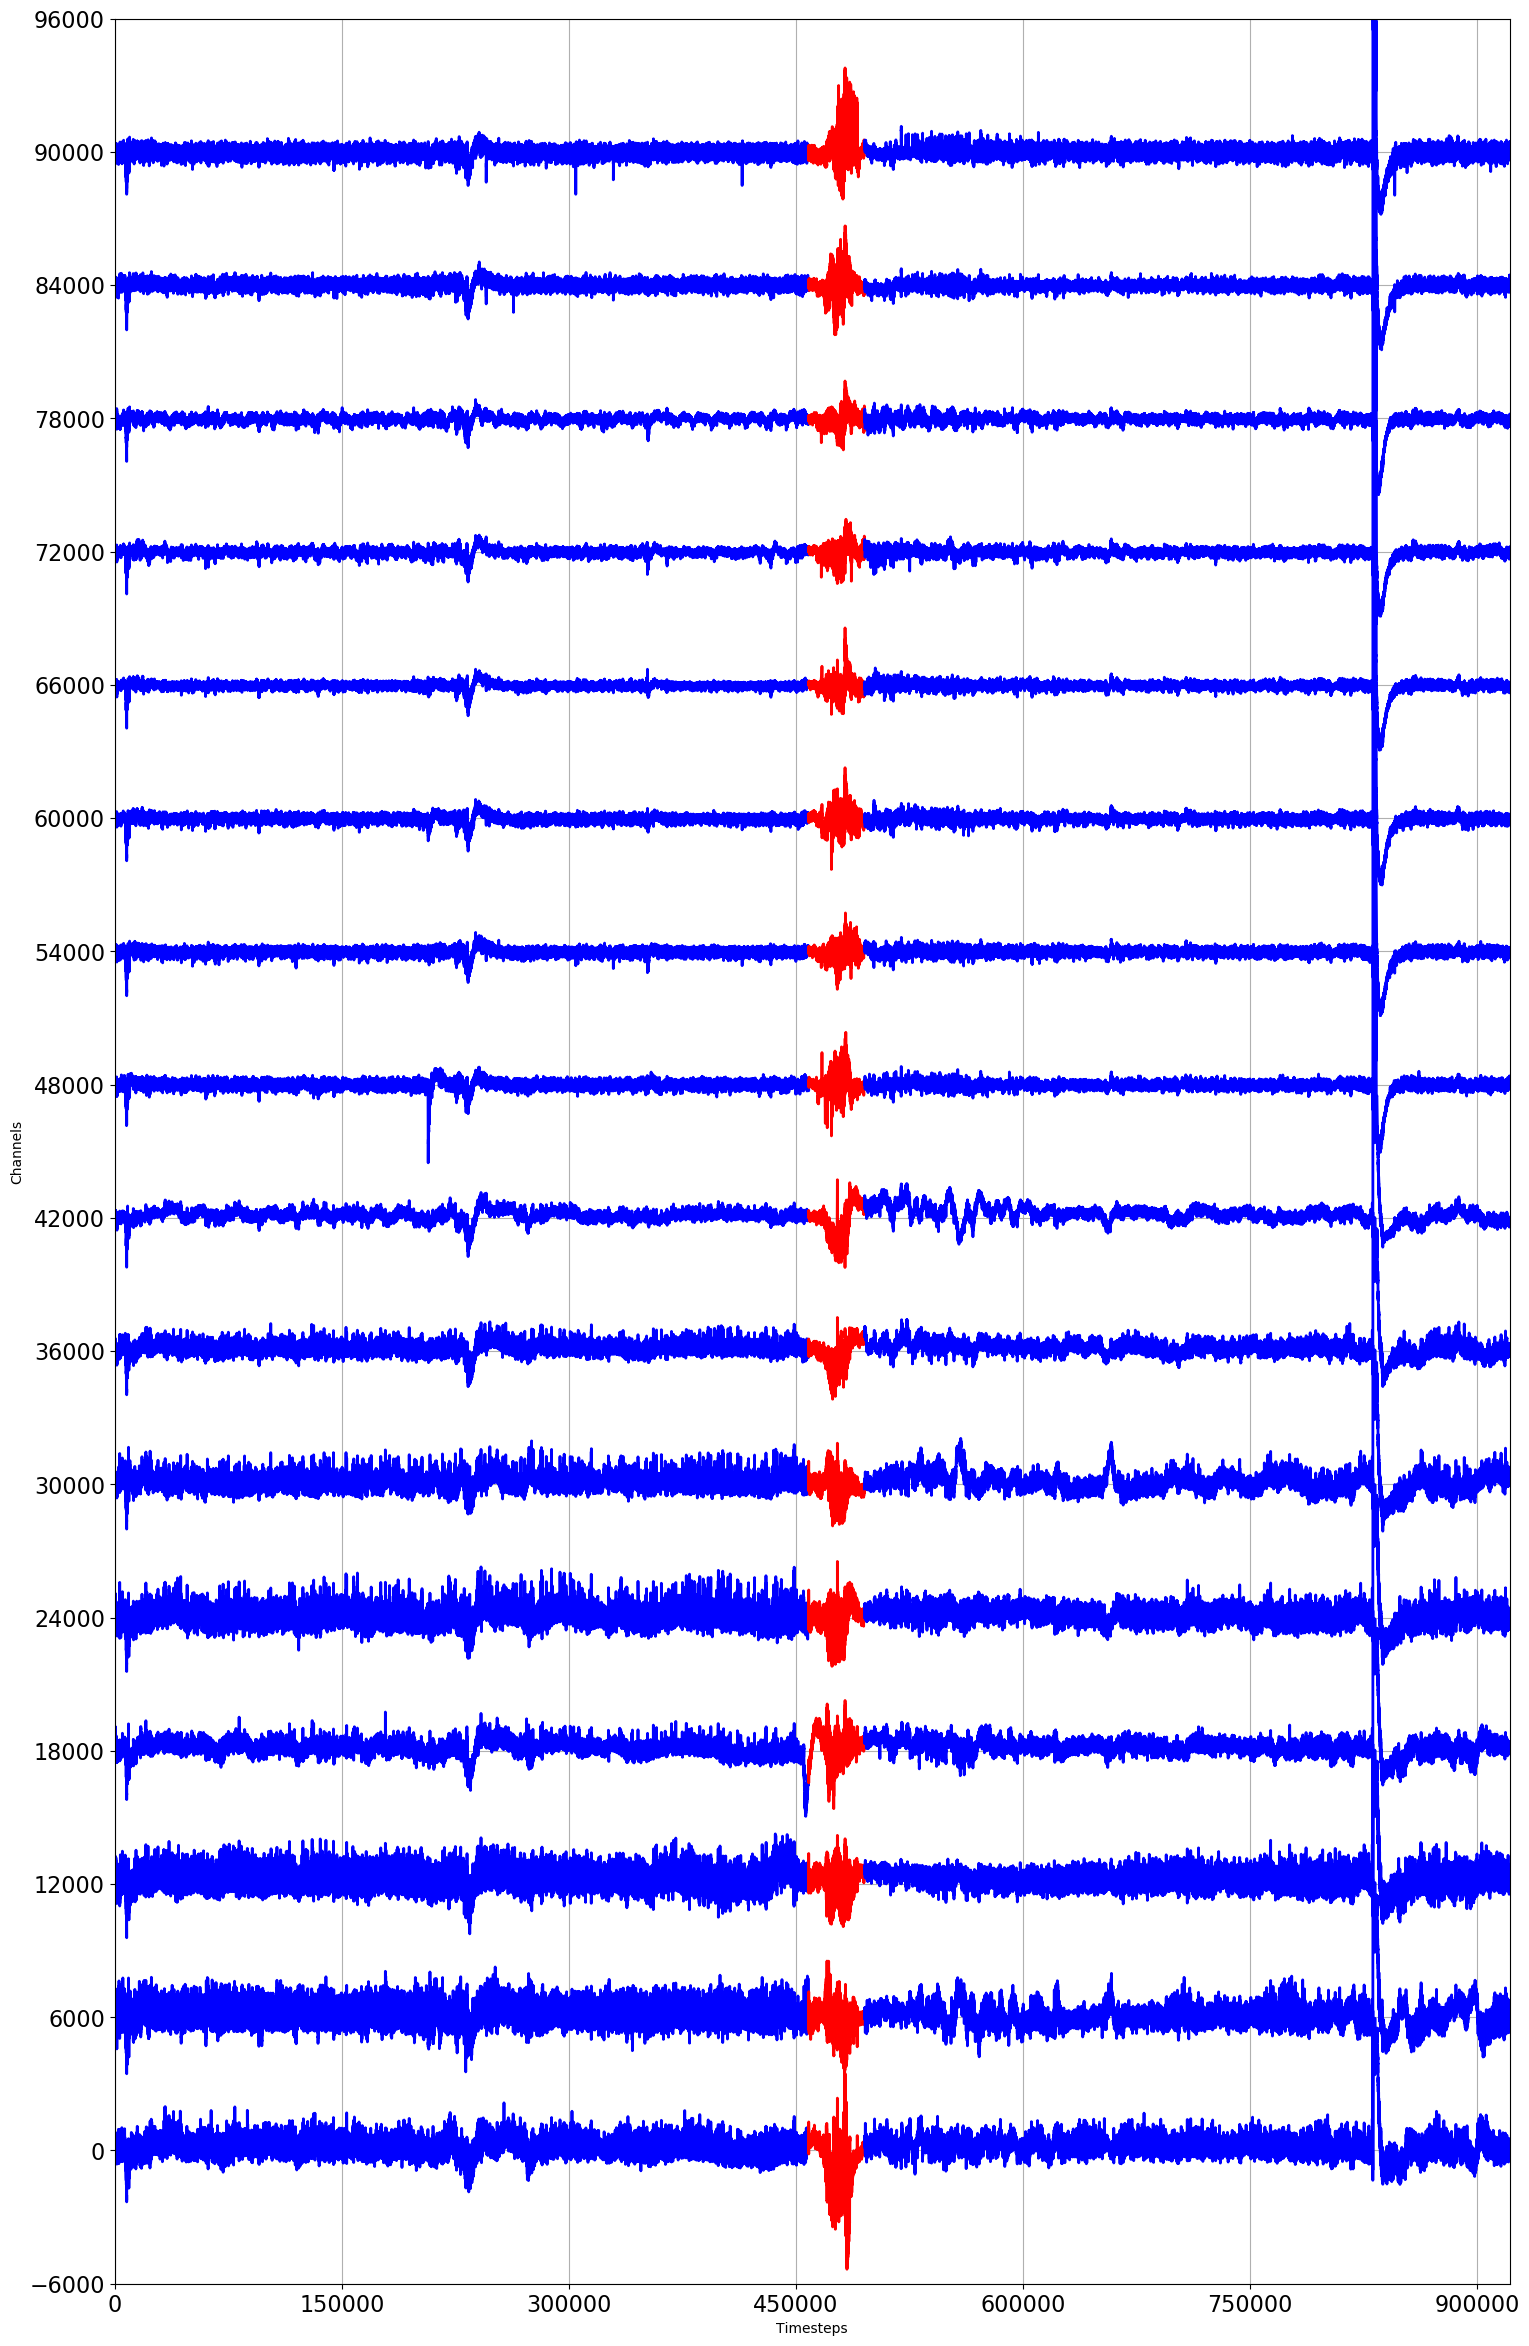

In [52]:
class xt_plot_subject:
    def __init__(self): 
        #
        self.fileIDStart = 0
        self.fileIDEnd = 1
        self.n_timestep = 256
        self.n_channel = 16
        #
        dir_in = []
        dir_ou = []
        #

# ======================================================
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(t,x,colors,i):
    segments = find_contiguous_colors(colors)
    plt.subplot(2, 1, i+1)
    plt.grid()
    #plt.legend()
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(t[start:end],x[start:end],lw=2,c=seg[0]) 
        start = end
        
# ======================================================
# Read the database and categorize no-seizure files
# and seizure files
# ======================================================
def xt_plot_generation(subject, std, zoom, filt):
    print('INFO: Load database')
        
    Xfull = []
    yfull = []
    #
    for idx in range (subject.fileIDStart, subject.fileIDEnd+1):
        tmp_db = EEGRecord()

        # Preprocess index idx
        idx_str = str(idx)
        if idx < 10:
            idx_str = '00' + idx_str
        elif idx < 100:
            idx_str = '0' + idx_str
            
        mat_file_path = os.path.join(subject.dir_in, 'EDMSE_pat_FR_1096_' + idx_str + '.mat')
        print('--- Debug: Open file ', mat_file_path)
        f = h5py.File(mat_file_path, 'r', libver='latest')

        tmp_db.id = int(f["record_idx"][0])
        tmp_db.filepath = mat_file_path
        tmp_db.fs = np.asscalar(f["Fs"][0])
        #tmp_db.raw_data = f["signal"]  # 921,600 rows x 16 cols
        #tmp_db.n_samples = tmp_db.raw_data[0]
        isSz = f["sample_sz_onset"][0]
        isSCSz = f["sample_scsz_onset"][0]
           
        # ----------- label ictal, interictal ----------------
        pos_sz_on = 0
        pos_sz_off = 0
            
        if(isSz):
            tmp_db.clin_onsets = np.asscalar(f["sample_sz_onset"][0])
            tmp_db.clin_onsets = np.asscalar(f[tmp_db.clin_onsets][0])
            tmp_db.clin_offsets = np.asscalar(f["sample_sz_end"][0])
            tmp_db.clin_offsets = np.asscalar(f[tmp_db.clin_offsets][0])
            pos_sz_on = tmp_db.clin_onsets
            pos_sz_off = tmp_db.clin_offsets
        #    
        elif (isSCSz):
            tmp_db.subclin_onsets = np.asscalar(f["sample_scsz_onset"][0])
            tmp_db.subclin_onsets = np.asscalar(f[tmp_db.subclin_onsets][0])
            tmp_db.subclin_offsets = np.asscalar(f["sample_scsz_end"][0])
            tmp_db.subclin_offsets = np.asscalar(f[tmp_db.subclin_offsets][0])
            pos_sz_on = tmp_db.subclin_onsets
            pos_sz_off = tmp_db.subclin_offsets
            
        #
        # Get data
        tmp_db.raw_data = np.asarray(f["signal"])  # 921,600 rows x 16 cols
        pos_sz_on = int(pos_sz_on)
        pos_sz_off = int(pos_sz_off)
        #tmp_db.raw_data = tmp_db.raw_data.T
        #n_step = int(tmp_db.raw_data.shape[0] / subject.n_timestep)
        print(pos_sz_on, pos_sz_off)
        
        if std == 0 and zoom == 0:
            M = 6000
        elif std == 0 and zoom == 1:
            M = 3000
        elif std == 1 :
            M = 10 
        N = tmp_db.raw_data.T.shape[0]
        
        fig = plt.figure(figsize=(18, 30), dpi= 100)       
        plt.ylim((-M, M*subject.n_channel))
        
        plt.rc('xtick', labelsize=16) 
        plt.rc('ytick', labelsize=16) 
        ax = plt.subplot(1, 1, 1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))        
        ax.yaxis.set_major_locator(plt.MaxNLocator(17))         
        ax.set_xlabel("Timesteps")
        ax.set_ylabel("Channels")
        ax.grid(True)
        
        xx = tmp_db.raw_data
        if filt == 1:
            xx = butter_lowpass_filter(xx, 64, subject.n_timestep, order=10)
            print(xx.max(), xx.min())
        if std == 1: 
            scaler = preprocessing.StandardScaler().fit(xx) 
            xx = scaler.transform(xx)
        
        for i in range (0, 16): 
            if zoom == 0:
                t = np.arange(N)
                plt.xlim((0, N))
                colors = ['blue']*pos_sz_on
                colors[pos_sz_on:pos_sz_off] = ['red']*(pos_sz_off - pos_sz_on)
                colors[pos_sz_off:N] = ['blue']*(N - pos_sz_off)
                x = xx[i]
                #plt.xscale('log')
                plt.grid()

                segments = find_contiguous_colors(colors)
                start = 0
                for seg in segments:
                    end = start + len(seg)
                    l, = plt.gca().plot(t[start:end], x[start:end] + i*M, lw=2, c=seg[0]) 
                    start = end
            #
            else:
                if pos_sz_on > 0:
                    header = 8192
                    t = np.arange(pos_sz_off - pos_sz_on + header * 2)
                    plt.xlim((0, 65536))
                    colors = ['blue']*header
                    colors[header:pos_sz_off-pos_sz_on+header] = ['red']*(pos_sz_off - pos_sz_on) 
                    colors[pos_sz_off-pos_sz_on+header:pos_sz_off-pos_sz_on+2 * header] = ['blue']*header
                    x = xx[i][pos_sz_on-header:pos_sz_off+header]
                    
                    #plt.xscale('log')
                    plt.grid()

                    segments = find_contiguous_colors(colors)
                    start = 0
                    for seg in segments:
                        end = start + len(seg)
                        l, = plt.gca().plot(t[start:end], x[start:end] + i*M, lw=2, c=seg[0]) 
                        start = end
        
        if zoom == 0 or (zoom == 1 and pos_sz_on > 0):
            plt.show()        
            #fig.savefig(os.path.join(subject.dir_ou, 'EDMSE_pat_FR_1096_' + idx_str + '.pdf'))
            

# ===============================================
# Test function
# ===============================================
patient = xt_plot_subject()
patient.fileIDStart = 126
patient.fileIDEnd = 126
patient.dir_in = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU')
patient.dir_ou = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_PLOT_ZOOM_STD')
std = 0
zoom = 0
filt = 1

xt_plot_generation(patient, std, zoom, filt)

INFO: Load database
--- Debug: Open file  D:\Romanlab\XT_DataSet\dataset3\RAW_EU\EDMSE_pat_FR_1096_126.mat
458430 495289


C:\nxt\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


6963.518580395773 -5341.711312441704


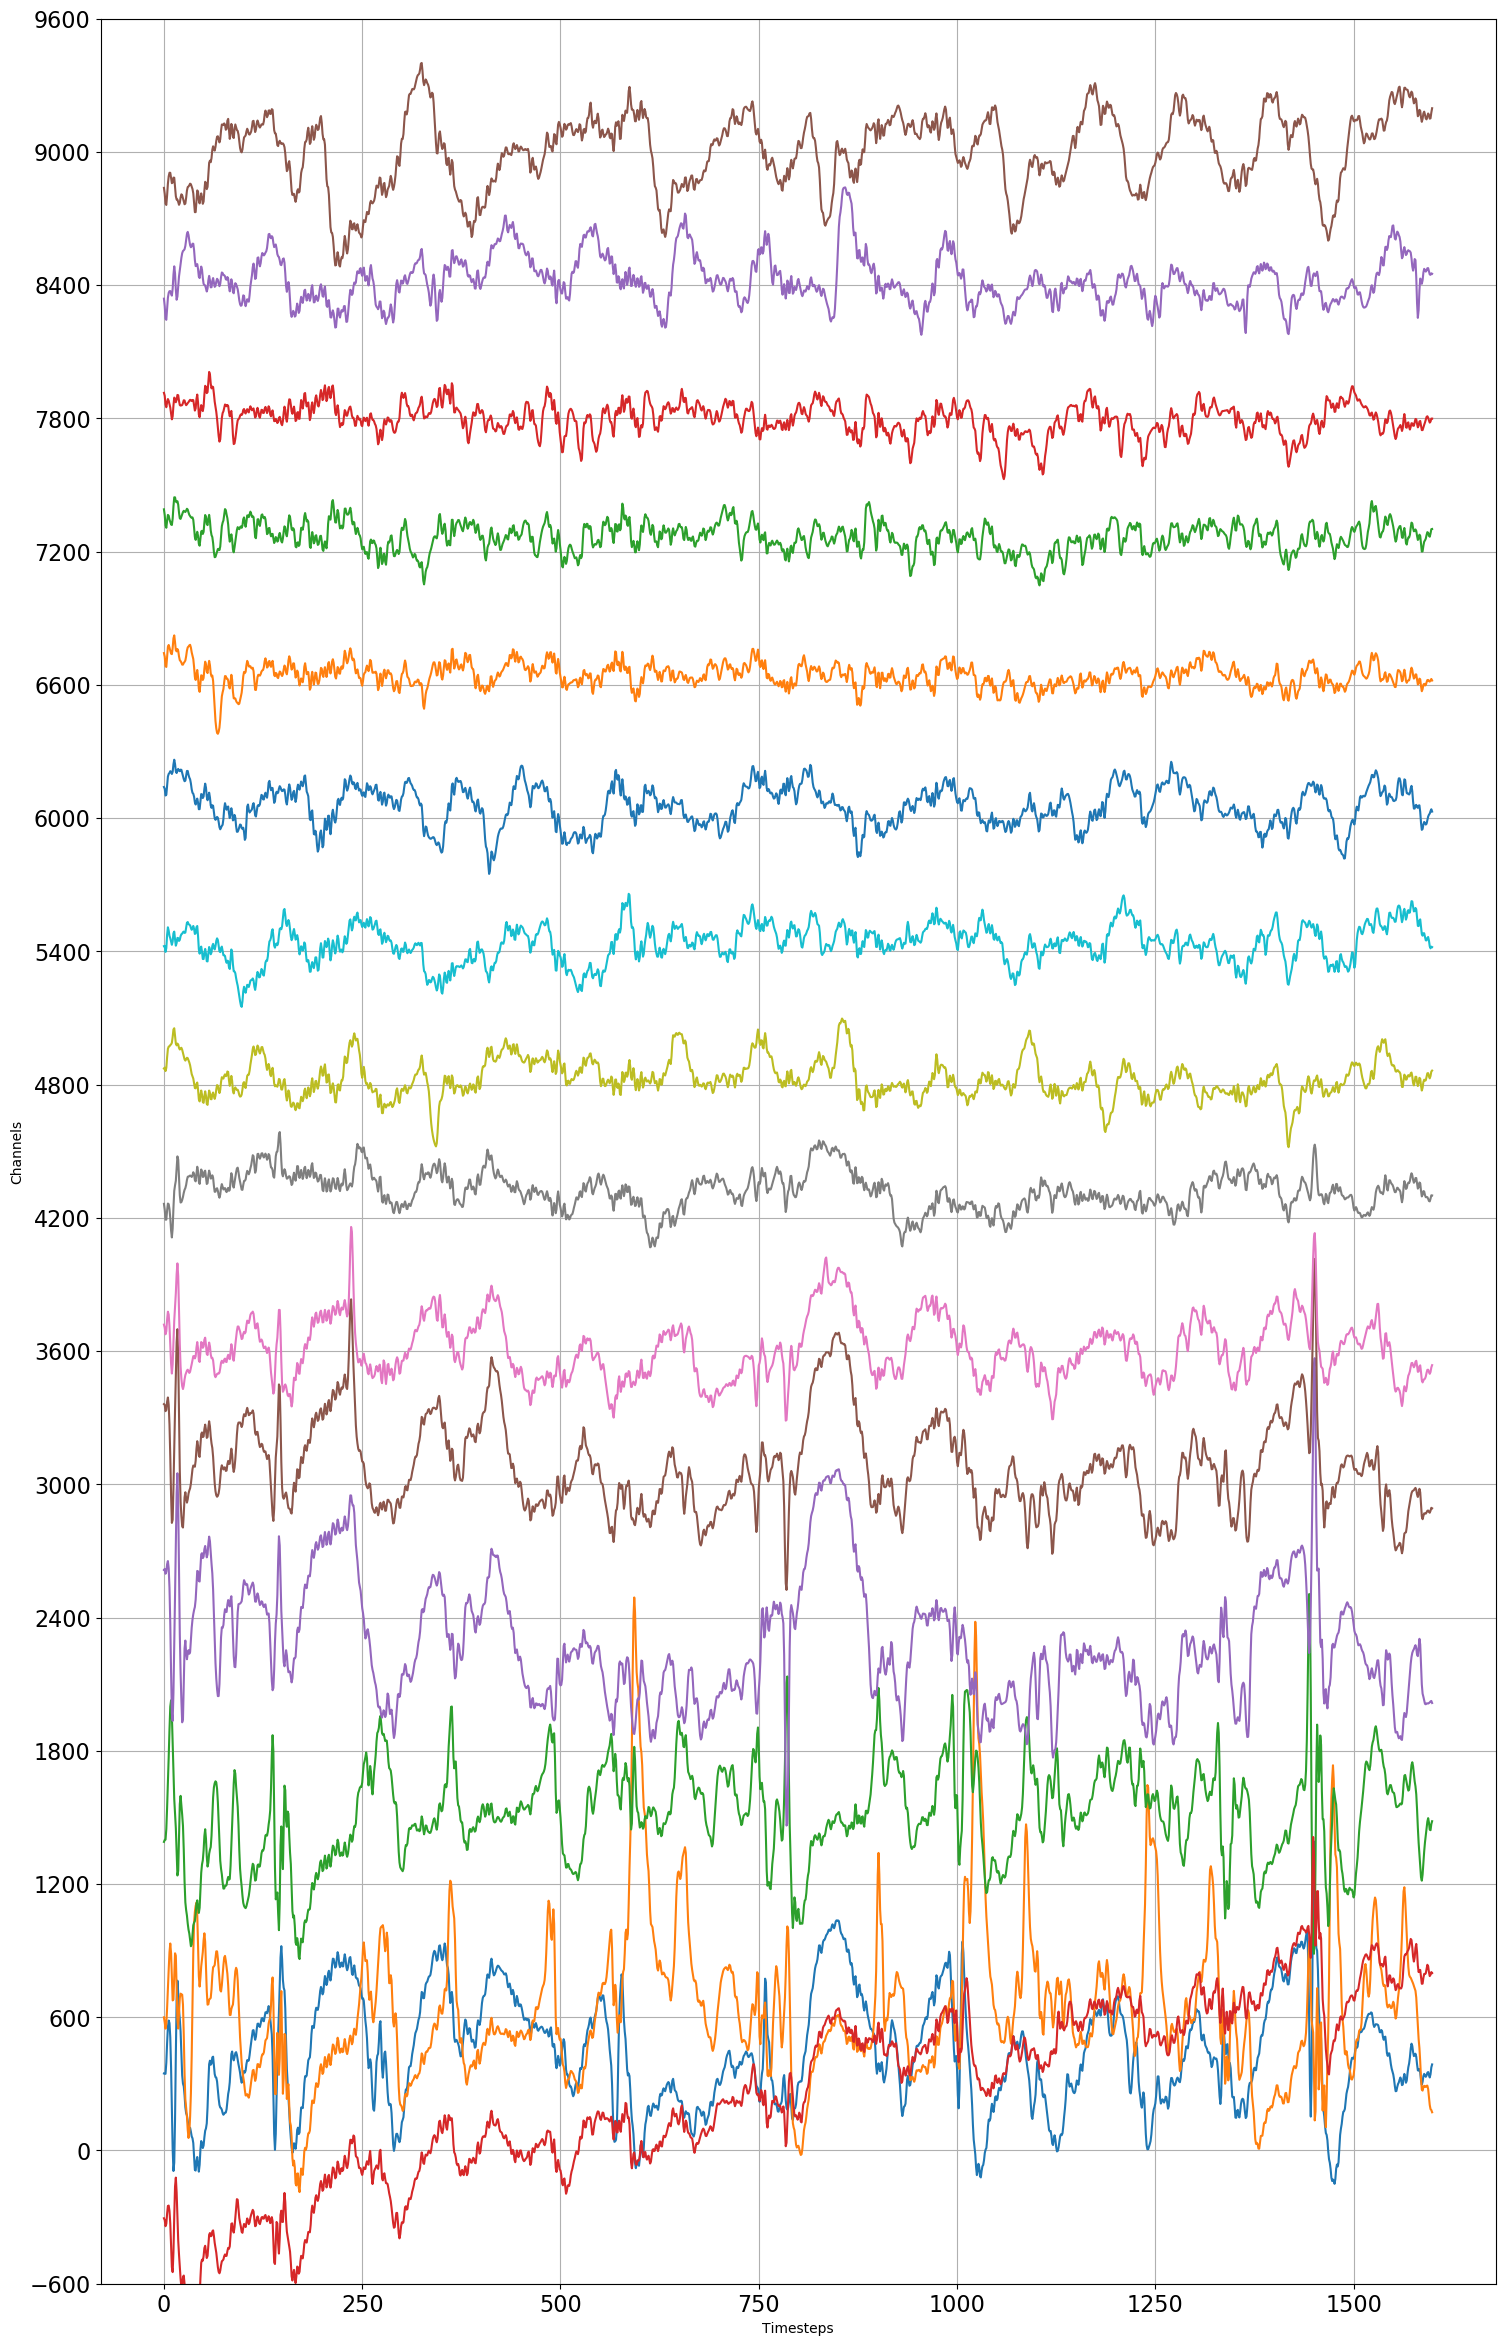

In [67]:
class xt_plot_subject:
    def __init__(self): 
        #
        self.fileIDStart = 0
        self.fileIDEnd = 1
        self.n_timestep = 256
        self.n_channel = 16
        #
        dir_in = []
        dir_ou = []
        #

# ======================================================
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(t,x,colors,i):
    segments = find_contiguous_colors(colors)
    plt.subplot(2, 1, i+1)
    plt.grid()
    #plt.legend()
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(t[start:end],x[start:end],lw=2,c=seg[0]) 
        start = end
        
# ======================================================
# Read the database and categorize no-seizure files
# and seizure files
# ======================================================
def xt_plot_generation(subject, std, zoom, filt):
    print('INFO: Load database')
        
    Xfull = []
    yfull = []
    #
    for idx in range (subject.fileIDStart, subject.fileIDEnd+1):
        tmp_db = EEGRecord()

        # Preprocess index idx
        idx_str = str(idx)
        if idx < 10:
            idx_str = '00' + idx_str
        elif idx < 100:
            idx_str = '0' + idx_str
            
        mat_file_path = os.path.join(subject.dir_in, 'EDMSE_pat_FR_1096_' + idx_str + '.mat')
        print('--- Debug: Open file ', mat_file_path)
        f = h5py.File(mat_file_path, 'r', libver='latest')

        tmp_db.id = int(f["record_idx"][0])
        tmp_db.filepath = mat_file_path
        tmp_db.fs = np.asscalar(f["Fs"][0])
        #tmp_db.raw_data = f["signal"]  # 921,600 rows x 16 cols
        #tmp_db.n_samples = tmp_db.raw_data[0]
        isSz = f["sample_sz_onset"][0]
        isSCSz = f["sample_scsz_onset"][0]
           
        # ----------- label ictal, interictal ----------------
        pos_sz_on = 0
        pos_sz_off = 0
            
        if(isSz):
            tmp_db.clin_onsets = np.asscalar(f["sample_sz_onset"][0])
            tmp_db.clin_onsets = np.asscalar(f[tmp_db.clin_onsets][0])
            tmp_db.clin_offsets = np.asscalar(f["sample_sz_end"][0])
            tmp_db.clin_offsets = np.asscalar(f[tmp_db.clin_offsets][0])
            pos_sz_on = tmp_db.clin_onsets
            pos_sz_off = tmp_db.clin_offsets
        #    
        elif (isSCSz):
            tmp_db.subclin_onsets = np.asscalar(f["sample_scsz_onset"][0])
            tmp_db.subclin_onsets = np.asscalar(f[tmp_db.subclin_onsets][0])
            tmp_db.subclin_offsets = np.asscalar(f["sample_scsz_end"][0])
            tmp_db.subclin_offsets = np.asscalar(f[tmp_db.subclin_offsets][0])
            pos_sz_on = tmp_db.subclin_onsets
            pos_sz_off = tmp_db.subclin_offsets
            
        #
        # Get data
        tmp_db.raw_data = np.asarray(f["signal"])  # 921,600 rows x 16 cols
        pos_sz_on = int(pos_sz_on)
        pos_sz_off = int(pos_sz_off)
        #tmp_db.raw_data = tmp_db.raw_data.T
        #n_step = int(tmp_db.raw_data.shape[0] / subject.n_timestep)
        print(pos_sz_on, pos_sz_off)
        
        if std == 0 and zoom == 0:
            M = 600
        elif std == 0 and zoom == 1:
            M = 3000
        elif std == 1 :
            M = 10 
        N = tmp_db.raw_data.T.shape[0]
        
        fig = plt.figure(figsize=(18, 30), dpi= 100)       
        plt.ylim((-M, M*subject.n_channel))
        
        plt.rc('xtick', labelsize=16) 
        plt.rc('ytick', labelsize=16) 
        ax = plt.subplot(1, 1, 1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))        
        ax.yaxis.set_major_locator(plt.MaxNLocator(17))         
        ax.set_xlabel("Timesteps")
        ax.set_ylabel("Channels")
        ax.grid(True)
        
        xx = tmp_db.raw_data
        if filt == 1:
            xx = butter_lowpass_filter(xx, 64, subject.n_timestep, order=20)
            print(xx.max(), xx.min())
        if std == 1: 
            scaler = preprocessing.StandardScaler().fit(xx) 
            xx = scaler.transform(xx)
        
        pos_sz_on = 0
        pos_sz_off = 512
        N = 512
        for i in range (0, 16): 
            if zoom == 0:

                x = xx[i][457000:458600]
                #plt.xscale('log')
                plt.grid()

                plt.plot(x + i*M)
            #
            else:
                if pos_sz_on > 0:
                    header = 8192
                    t = np.arange(pos_sz_off - pos_sz_on + header * 2)
                    plt.xlim((0, 65536))
                    colors = ['blue']*header
                    colors[header:pos_sz_off-pos_sz_on+header] = ['red']*(pos_sz_off - pos_sz_on) 
                    colors[pos_sz_off-pos_sz_on+header:pos_sz_off-pos_sz_on+2 * header] = ['blue']*header
                    x = xx[i][pos_sz_on-header:pos_sz_off+header]
                    
                    #plt.xscale('log')
                    plt.grid()

                    segments = find_contiguous_colors(colors)
                    start = 0
                    for seg in segments:
                        end = start + len(seg)
                        l, = plt.gca().plot(t[start:end], x[start:end] + i*M, lw=2, c=seg[0]) 
                        start = end
        
        if zoom == 0 or (zoom == 1 and pos_sz_on > 0):
            plt.show()        
            #fig.savefig(os.path.join(subject.dir_ou, 'EDMSE_pat_FR_1096_' + idx_str + '.pdf'))
            

# ===============================================
# Test function
# ===============================================
patient = xt_plot_subject()
patient.fileIDStart = 126
patient.fileIDEnd = 126
patient.dir_in = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU')
patient.dir_ou = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_PLOT_ZOOM_STD')
std = 0
zoom = 0
filt = 1

xt_plot_generation(patient, std, zoom, filt)

# CHECK HISTOGRAM

Done


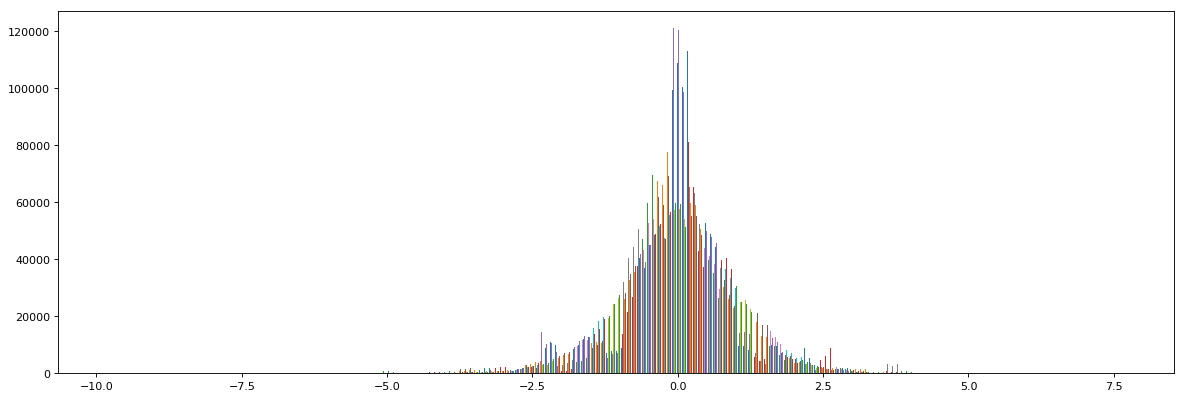

In [41]:
import numpy as np 
import matplotlib.pyplot as plt

dir_in = 'D:\Romanlab\XT_DataSet\dataset3\RAW_EU_OO5'
fileID = 0 
n_timestep = 256 #400
n_channel= 16


file_train = os.path.join(dir_in, 'Xtrain_' + str(fileID))

X_train = np.loadtxt(file_train, delimiter=' ') 
#X_train = np.loadtxt(file_train, delimiter=' ', usecols=(10)) 

fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(X_train, bins=200) 
#plt.axis([-500, 500, 0, 1000000]) 
print('Done')

# CHECK RESULTS

(3600,) (3600,)
=== Raw results === 
Diff = 79
tn, fp, fn, tp, sens, spec = 3417 61 18 104 0.8524590163934426 0.9824611845888441
=== Filtered results === 
Diff = 122
tn, fp, fn, tp, sens, spec = 3478 0 122 0 0.0 1.0


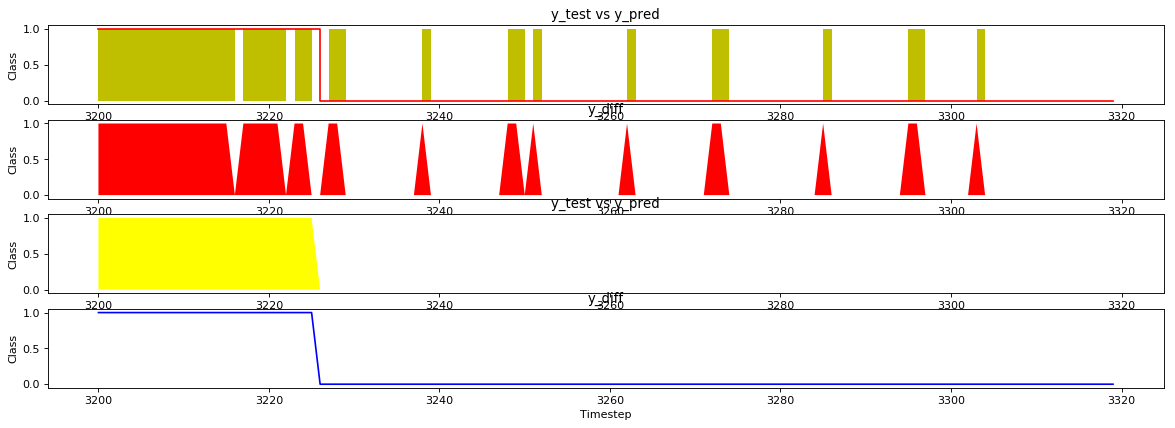

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score 


#file_in = '.\Results\\test-pred--date--id.k.bs.cw.hu1.hu2.hu3--2018.07.23.12.16--Dog_.0.64.1.32.0.0'
file_in = '.\Results_10a\\test-pred--date--id.k.bs.cw.hu1.hu2.hu3--2018.08.17.18.53--Patient_1.0.8192.1.32.0.0'

#X_train = np.loadtxt(file_train, delimiter=' ', usecols=(range(9, 9))) 
[y_test, y_pred] = np.loadtxt(file_in, delimiter=' ') 
print(y_test.shape, y_pred.shape)

fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

start = 3200
end = 3320 #y_test.shape[0]
t = range (start, end)

# ==============================================
print('=== Raw results === ')

plt.subplot(4, 1, 1)
#plt.fill_between(t, y_test[start:end], facecolor='yellow')
plt.fill_between(t, y_pred[start:end], facecolor='y', step="post")
plt.plot(t, y_test[start:end], color='r', drawstyle='steps-post') 
#plt.plot(t, y_pred[start:end], color='b', linestyle=':')
plt.title('y_test vs y_pred')
plt.ylabel('Class')

plt.subplot(4, 1, 2)
y_diff = y_test != y_pred
#plt.plot(t, y_diff[start:end], color='b') 
plt.fill_between(t, y_pred[start:end], facecolor='red')
plt.title('y_diff')
plt.xlabel('Timestep')
plt.ylabel('Class')
print('Diff =', np.sum(y_diff))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sens = tp/(tp + fn)
spec = tn/(fp + tn)
print('tn, fp, fn, tp, sens, spec =', tn, fp, fn, tp, sens, spec)

# ==============================================
print('=== Filtered results === ')
prev_value = 1
threshold = 80
y_pred_avg = np.ones(y_pred.shape[0])
p = 0.995   

for i in range (0, y_pred.shape[0] ):
    if i == 0:
        y_pred_avg[i] = y_pred[i]
    else:
        y_pred_avg[i] = y_pred[i] * (1 - p) + y_pred_avg[i-1] * p
        
y_pred_avg = np.round(y_pred_avg)        
        
plt.subplot(4, 1, 3)
plt.fill_between(t, y_test[start:end], facecolor='yellow')
plt.fill_between(t, y_pred_avg[start:end], facecolor='red')
#plt.plot(t, y_test[start:end], color='r') 
#plt.plot(t, y_pred[start:end], color='b', linestyle=':')
plt.title('y_test vs y_pred')
plt.ylabel('Class')

plt.subplot(4, 1, 4)
y_diff = y_test != y_pred_avg 
plt.plot(t, y_diff[start:end], color='b') 
plt.title('y_diff')
plt.xlabel('Timestep')
plt.ylabel('Class')
print('Diff =', np.sum(y_diff))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_avg).ravel()
sens = tp/(tp + fn)
spec = tn/(fp + tn)
print('tn, fp, fn, tp, sens, spec =', tn, fp, fn, tp, sens, spec)

In [11]:
import keras
from keras import optimizers
import keras.backend as K
from keras.models import Sequential, Model, load_model
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, fbeta_score
import numpy as np
import collections
import os
import argparse

import datetime as dt
import random
import scipy.io as spio
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

def xt_k_of_n(y_pred, y_test, tsuf, k, n):
    print('------ Debug: tsuf, k, n =', tsuf, k, n)
    
    rec_73 = [3105, 3226]
    rec_75 = [3367, 3481]
    rec_96 = [2718, 2836]
    rec_101 = [623, 744]
    rec_120 = [2041, 2198]
    rec_122 = [324, 447]
    rec_124 = [2772, 2893]
    rec_126 = [1791, 1935]
    
    if tsuf == '73_73':
        rec = rec_73
    elif tsuf == '75_75':
        rec = rec_75
    elif tsuf == '96_96':
        rec = rec_96
    elif tsuf == '101_101':
        rec = rec_101
    elif tsuf == '120_120':
        rec = rec_120
    elif tsuf == '122_122':
        rec = rec_122
    elif tsuf == '124_124':
        rec = rec_124
    elif tsuf == '126_126':
        rec = rec_126
    else:
        rec = [0, 0]
    
    M = y_pred.shape[0]
    y_pred_tmp = np.zeros(M)
    if k > 1 and n > 1:
#         print('------ Debug: FILTER')
        for i in range (0, M):
            if (i >= n-1) and (np.sum(y_pred[i-n:i]) >= k):
                y_pred_tmp[i] = 1
    else:
        y_pred_tmp = y_pred
    
#     print('------ Debug: LATENCY')
    latency = 0
    if rec != [0, 0]:
#         print('------ Debug: ', rec)
        for i in range(rec[0], rec[1]):
#             print('------ Debug: ', y_test[i], y_pred_tmp[i])
            if (y_test[i] == 1) and (y_pred_tmp[i] == 0):
                latency = latency + 1
            elif (y_test[i] == y_pred_tmp[i]):
                break;
    
    print('------ Debug: FP')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tmp, labels=[0,1]).ravel()

    return latency, fp

# =============================================
def xt_eval_subset(X_test, y_test, batch_size, tsuf, k, n, best_model_name):        
    # Load best model
    best_model = load_model(best_model_name)

    # Loss, Accuracy
    # Ref: https://keras.io/models/model/
    test_loss, test_acc = best_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=batch_size)

    # Ref: https://keras.io/models/model/
    y_pred = best_model.predict(X_test, 
                                verbose=0,
                                batch_size=batch_size,
                                steps=None)

    # Flatten y_test and y_pred
    #print('------ Debug: y_test.shape =', y_test.shape)
    dim = y_test.shape 
    y_pred_ = y_pred.reshape(dim[0] * dim[1])
    y_pred_ = np.round(y_pred_)
    y_test_ = y_test.reshape(dim[0] * dim[1])
#     print(y_test_, y_pred_)

#     # TN, FP, FN, TP, AUC, sensitivity, specificity, AUC
#     # Ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#     tn, fp, fn, tp = confusion_matrix(y_test_, y_pred_, labels=[0,1]).ravel()
#     sens = tp/(tp + fn)
#     spec = tn/(fp + tn)
#     #auc = roc_auc_score(y_test_, y_pred_)
#     auc = 0
    
#     print('test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc =', test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc)
    
#     return test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc 

    latency, fp = xt_k_of_n(y_pred_, y_test_, tsuf, k, n)
    print('--- Debug: latency, fp =', latency, fp)
    return latency, fp
       
# ==================================================
# Test function
cnt_fp = 0
model_suffix = '1E_T'

if model_suffix == '1_T':
    train_set = [75, 96, 101, 120, 122, 124, 126, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133]
elif model_suffix == '2_T':
    train_set = [96, 101, 120, 122, 124, 126, 73, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133]
elif model_suffix == '3_T':
    train_set = [101, 120, 122, 124, 126, 73, 75, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133]    
elif model_suffix == '4_T':
    train_set = [120, 122, 124, 126, 73, 75, 96, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133]    
elif model_suffix == '5_T':
    train_set = [122, 124, 126, 73, 75, 96, 101, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133]        
elif model_suffix == '6_T':
    train_set = [124, 126, 73, 75, 96, 101, 120, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133]        
elif model_suffix == '7_T':
    train_set = [126, 73, 75, 96, 101, 120, 122, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133] 
elif model_suffix == '8_T':
    train_set = [73, 75, 96, 101, 120, 122, 124, 78, 98, 99, 111, 112, 113, 128, 129, 130, 131, 132, 133]    
elif model_suffix == '1D_T':
    train_set = [73, 75, 96, 101, 120, 55, 78, 98, 99, 113, 128, 129, 130] 
elif model_suffix == '2D_T':
    train_set = [73, 75, 96, 101, 120, 122, 55, 78, 98, 99, 112, 113, 128, 129, 130] 
elif model_suffix == '3D_T':
    train_set = [73, 75, 96, 101, 120, 122, 124, 55, 78, 98, 99, 112, 113, 128, 129, 130, 131, 132] 
elif model_suffix == '1E_T':
    train_set = [73, 75, 96, 101, 120, 55, 78, 98, 99, 104, 105, 113, 114] 

print('INFO: Start')

n_channel = 80
n_timestep = 1
batch_size = 64
dnn = 'dense'

# ---------------------
results = []
k, n = 3, 5
for i in range (1, 165):
    if i != 19 and i != 69 and i != 92 and i != 116:
        tsuf = str(i) + '_' + str(i)
        file_Xin = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TEST_A', 'X_' + tsuf + '.csv')
        file_yin = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TEST_A', 'y_' + tsuf + '.csv')

        #
        X_test = pd.read_csv(file_Xin, delimiter=",", header=None).values
        y_test = pd.read_csv(file_yin, delimiter=",", header=None).values

        #
        dim = X_test.shape[0]
        X_test = X_test.reshape((int(dim/n_timestep), n_timestep, n_channel))
        y_test = y_test.reshape((int(dim/n_timestep), 1))

        #
        for msuf in range (3, 4):
            file_Xmean = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_' + model_suffix, 'Xmean_0.csv')
            file_Xstd = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_' + model_suffix, 'Xstd_0.csv')

            #
            X_mean = pd.read_csv(file_Xmean, delimiter=",", header=None).values 
            X_mean = X_mean.T
            X_std = pd.read_csv(file_Xstd, delimiter=",", header=None).values
            X_std = X_std.T

            X_test_tmp = (X_test - X_mean) / X_std

            #np.savetxt('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_1_16T\\tmp', X_test_tmp, delimiter=' ', fmt='%.2f')
            if dnn == 'rnn':
                X_test_tmp = X_test_tmp.reshape(int(dim/n_timestep), n_timestep, n_channel)
            elif dnn == 'dense':
                X_test_tmp = X_test_tmp.reshape(dim, n_channel)
            elif dnn == 'cnn2d':
                X_test_tmp = X_test_tmp.reshape(int(dim/n_timestep), n_timestep, 16, int(n_channel/16))

            #print(X_mean, X_std, X_test)

            print('--- Debug: tsuf, msuf =', tsuf, msuf)
            result = xt_eval_subset(X_test_tmp, y_test, batch_size, tsuf, k, n, \
                           #'./Model_10a/best-model--' + model_suffix + '_' + dnn + '_' + str(msuf) + '_0') 
                                    './Model_10a/20180816_Model/best-model--1E_T_1dense_00')
            results.append(result)
            
            if (i not in train_set) and (result[1] > 0):
                cnt_fp = cnt_fp + 1
            print('--- Debug: cnt_fp =', cnt_fp)

np.savetxt('./Results_10a/20180816_full_result09a.csv', results, delimiter=',', fmt='%.2f')        
print('INFO: Done')

Using TensorFlow backend.


INFO: Start
--- Debug: tsuf, msuf = 1_1 3
3600/3600 [==============================] - 0s 18us/step
------ Debug: tsuf, k, n = 1_1 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 0
--- Debug: tsuf, msuf = 2_2 3
3600/3600 [==============================] - 0s 20us/step
------ Debug: tsuf, k, n = 2_2 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 0
--- Debug: tsuf, msuf = 3_3 3
3600/3600 [==============================] - 0s 23us/step
------ Debug: tsuf, k, n = 3_3 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 0
--- Debug: tsuf, msuf = 4_4 3
3600/3600 [==============================] - 0s 25us/step
------ Debug: tsuf, k, n = 4_4 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 0
--- Debug: tsuf, msuf = 5_5 3
3600/3600 [==============================] - 0s 27us/step
------ Debug: tsuf, k, n = 5_5 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 0
--- Debug: tsuf, msuf = 6_6 3
360

3600/3600 [==============================] - 1s 140us/step
------ Debug: tsuf, k, n = 44_44 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 1
--- Debug: tsuf, msuf = 45_45 3
3600/3600 [==============================] - 1s 141us/step
------ Debug: tsuf, k, n = 45_45 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 1
--- Debug: tsuf, msuf = 46_46 3
3600/3600 [==============================] - 1s 156us/step
------ Debug: tsuf, k, n = 46_46 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 1
--- Debug: tsuf, msuf = 47_47 3
3600/3600 [==============================] - 1s 149us/step
------ Debug: tsuf, k, n = 47_47 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 1
--- Debug: tsuf, msuf = 48_48 3
3600/3600 [==============================] - 1s 151us/step
------ Debug: tsuf, k, n = 48_48 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 1
--- Debug: tsuf, msuf = 49_49 3
3600/3600 [=========

3600/3600 [==============================] - 1s 274us/step
------ Debug: tsuf, k, n = 87_87 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 4
--- Debug: tsuf, msuf = 88_88 3
3600/3600 [==============================] - 1s 306us/step
------ Debug: tsuf, k, n = 88_88 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 4
--- Debug: tsuf, msuf = 89_89 3
3600/3600 [==============================] - 1s 279us/step
------ Debug: tsuf, k, n = 89_89 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 4
--- Debug: tsuf, msuf = 90_90 3
3600/3600 [==============================] - 1s 292us/step
------ Debug: tsuf, k, n = 90_90 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 4
--- Debug: tsuf, msuf = 91_91 3
3600/3600 [==============================] - 1s 311us/step
------ Debug: tsuf, k, n = 91_91 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 4
--- Debug: tsuf, msuf = 93_93 3
3600/3600 [=========

3600/3600 [==============================] - 2s 462us/step
------ Debug: tsuf, k, n = 130_130 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 10
--- Debug: tsuf, msuf = 131_131 3
3600/3600 [==============================] - 2s 445us/step
------ Debug: tsuf, k, n = 131_131 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 10
--- Debug: tsuf, msuf = 132_132 3
3600/3600 [==============================] - 2s 451us/step
------ Debug: tsuf, k, n = 132_132 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 10
--- Debug: tsuf, msuf = 133_133 3
3600/3600 [==============================] - 2s 471us/step
------ Debug: tsuf, k, n = 133_133 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 10
--- Debug: tsuf, msuf = 134_134 3
3600/3600 [==============================] - 2s 464us/step
------ Debug: tsuf, k, n = 134_134 3 5
------ Debug: FP
--- Debug: latency, fp = 0 0
--- Debug: cnt_fp = 10
--- Debug: tsuf, msuf = 135_1

In [2]:
np.savetxt('./Results_10a/20180816_full_result09a.csv', results, delimiter=',', fmt='%.2f')    

INFO: Start
--- Debug: tsuf, msuf = 124_124 0
3600/3600 [==============================] - 0s 72us/step
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]
test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc = 0.0753894610135245 0.9947222222222222 102 18 3479 1 0.85 0.9997126436781609 0
------ Debug: tsuf, k, n = 124_124 3 5
------ Debug: FP
latency, fp = 20 2
=== Raw results === 
--- Debug: tsuf, msuf = 126_126 0
3600/3600 [==============================] - 0s 92us/step
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]
test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc = 0.1700009184558823 0.9869444444444444 102 42 3451 5 0.7083333333333334 0.9985532407407407 0
------ Debug: tsuf, k, n = 126_126 3 5
------ Debug: FP
latency, fp = 27 0
=== Raw results === 
INFO: Done


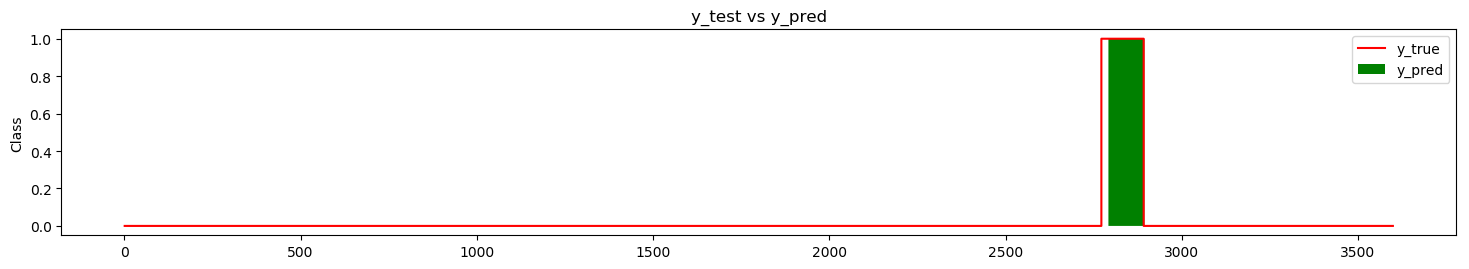

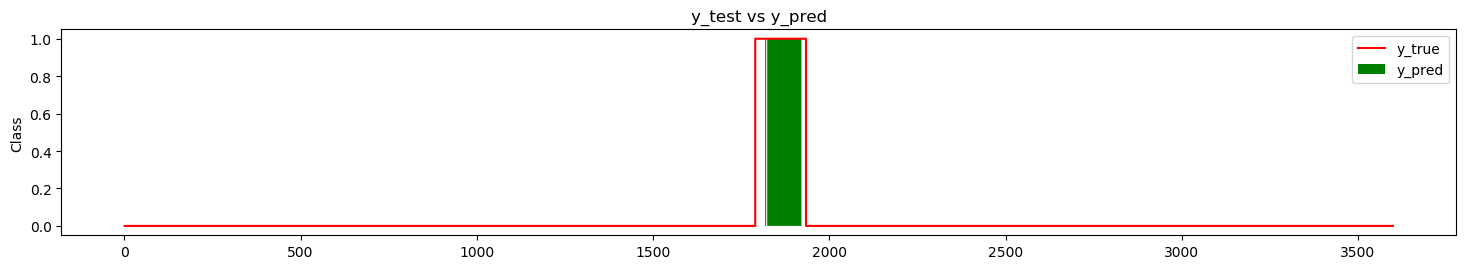

In [2]:
import keras
from keras import optimizers
import keras.backend as K
from keras.models import Sequential, Model, load_model
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, fbeta_score

import numpy as np
import datetime as dt
import random, os
import scipy.io as spio
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

def xt_k_of_n(y_pred, y_test, tsuf, k, n):
    print('------ Debug: tsuf, k, n =', tsuf, k, n)
    
    rec_73 = [3105, 3226]
    rec_75 = [3367, 3481]
    rec_96 = [2718, 2836]
    rec_101 = [623, 744]
    rec_120 = [2041, 2198]
    rec_122 = [324, 447]
    rec_124 = [2772, 2893]
    rec_126 = [1791, 1935]
    
    if tsuf == '73_73':
        rec = rec_73
    elif tsuf == '75_75':
        rec = rec_75
    elif tsuf == '96_96':
        rec = rec_96
    elif tsuf == '101_101':
        rec = rec_101
    elif tsuf == '120_120':
        rec = rec_120
    elif tsuf == '122_122':
        rec = rec_122
    elif tsuf == '124_124':
        rec = rec_124
    elif tsuf == '126_126':
        rec = rec_126
    else:
        rec = [0, 0]
    
    M = y_pred.shape[0]
    y_pred_tmp = np.zeros(M)
    if k > 1 and n > 1:
#         print('------ Debug: FILTER')
        for i in range (0, M):
            if (i >= n-1) and (np.sum(y_pred[i-n:i]) >= k):
                y_pred_tmp[i] = 1
    else:
        y_pred_tmp = y_pred
    
#     print('------ Debug: LATENCY')
    latency = 0
    if rec != [0, 0]:
#         print('------ Debug: ', rec)
        for i in range(rec[0], rec[1]):
#             print('------ Debug: ', y_test[i], y_pred_tmp[i])
            if (y_test[i] == 1) and (y_pred_tmp[i] == 0):
                latency = latency + 1
            elif (y_test[i] == y_pred_tmp[i]):
                break;
    
    print('------ Debug: FP')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tmp, labels=[0,1]).ravel()

    return latency, fp, y_pred_tmp

# =============================================
def xt_eval_subset(X_test, y_test, batch_size, tsuf, k, n, best_model_name):        
    # Load best model
    best_model = load_model(best_model_name)

    # Loss, Accuracy
    # Ref: https://keras.io/models/model/
    test_loss, test_acc = best_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=batch_size)

    # Ref: https://keras.io/models/model/
    y_pred = best_model.predict(X_test, 
                                verbose=0,
                                batch_size=batch_size,
                                steps=None)

    # Flatten y_test and y_pred
    #print('------ Debug: y_test.shape =', y_test.shape)
    dim = y_test.shape 
    y_pred_ = y_pred.reshape(dim[0] * dim[1])
    y_pred_ = np.round(y_pred_)
    y_test_ = y_test.reshape(dim[0] * dim[1])
    print(y_test_, y_pred_)

    # TN, FP, FN, TP, AUC, sensitivity, specificity, AUC
    # Ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    tn, fp, fn, tp = confusion_matrix(y_test_, y_pred_, labels=[0,1]).ravel()
    sens = tp/(tp + fn)
    spec = tn/(fp + tn)
    #auc = roc_auc_score(y_test_, y_pred_)
    auc = 0
    
    print('test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc =', test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc)   
    

    latency, fp, y_pred_ = xt_k_of_n(y_pred_, y_test_, tsuf, k, n)
    print('latency, fp =', latency, fp)
    
    # ==============================================
    fig=plt.figure(figsize=(18, 6), dpi= 100, facecolor='w', edgecolor='k')

    start = 1
    end = 3600 #y_test.shape[0]
    t = range (start, end)

    print('=== Raw results === ')

    plt.subplot(2, 1, 1)
    #plt.fill_between(t, y_test[start:end], facecolor='yellow')
    plt.fill_between(t, y_pred_[start:end], facecolor='g', step="post", label='y_pred')
    plt.plot(t, y_test_[start:end], color='r', drawstyle='steps-post', label='y_true') 
    #plt.plot(t, y_pred[start:end], color='b', linestyle=':')
    plt.title('y_test vs y_pred')
    plt.ylabel('Class')
    plt.legend()
    #fig.savefig('D:\\Romanlab\\XT_Projects\\04_rnn\\report_20180819\\results_01D\\REC' + tsuf + '_FC.pdf')
    # ==============================================
    
    return test_loss, test_acc, tp, fn, tn, fp, sens, spec, auc        
# ==================================================
# Test function
model_suffix = '3D_T'

if model_suffix == '1_T':
    test_suffix = ['73_73']
elif model_suffix == '2_T':
    test_suffix = ['75_75']
elif model_suffix == '3_T':
    test_suffix = ['96_96']
elif model_suffix == '4_T':
    test_suffix = ['101_101']
elif model_suffix == '5_T':
    test_suffix = ['120_120']
elif model_suffix == '6_T':
    test_suffix = ['122_122']
elif model_suffix == '7_T':
    test_suffix = ['124_124']
elif model_suffix == '8_T':
    test_suffix = ['126_126']
elif model_suffix == '1D_T':
    test_suffix = ['122_122', '124_124', '126_126']
elif model_suffix == '2D_T':
    test_suffix = ['124_124', '126_126']
elif model_suffix == '3D_T':
    test_suffix = ['124_124', '126_126']

#test_suffix = ['57_57']
print('INFO: Start')

n_channel = 80
n_timestep = 1
batch_size = 64
dnn = 'rnn'

# ---------------------
results = []
k, n = 3, 5
for tsuf in test_suffix:
    file_Xin = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TEST_A', 'X_' + tsuf + '.csv')
    file_yin = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TEST_A', 'y_' + tsuf + '.csv')
        
    #
    X_test = pd.read_csv(file_Xin, delimiter=",", header=None).values
    y_test = pd.read_csv(file_yin, delimiter=",", header=None).values

    #
    dim = X_test.shape[0]
    X_test = X_test.reshape((int(dim/n_timestep), n_timestep, n_channel))
    y_test = y_test.reshape((int(dim/n_timestep), 1))

    #
    for msuf in range (0, 1):
        file_Xmean = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_' + model_suffix, 'Xmean_0.csv')
        file_Xstd = os.path.join('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_' + model_suffix, 'Xstd_0.csv')
        
        #
        X_mean = pd.read_csv(file_Xmean, delimiter=",", header=None).values 
        X_mean = X_mean.T
        X_std = pd.read_csv(file_Xstd, delimiter=",", header=None).values
        X_std = X_std.T
        
        X_test_tmp = (X_test - X_mean) / X_std
        
        #np.savetxt('D:\Romanlab\XT_DataSet\dataset3\RAW_EU_TESTCASE_1_16T\\tmp', X_test_tmp, delimiter=' ', fmt='%.2f')
        if dnn == 'rnn':
            X_test_tmp = X_test_tmp.reshape(int(dim/n_timestep), n_timestep, n_channel)
        elif dnn == 'dense':
            X_test_tmp = X_test_tmp.reshape(dim, n_channel)
        elif dnn == 'cnn2d':
            X_test_tmp = X_test_tmp.reshape(int(dim/n_timestep), n_timestep, 16, int(n_channel/16))
        
        #print(X_mean, X_std, X_test)
    
        print('--- Debug: tsuf, msuf =', tsuf, msuf)
        result = xt_eval_subset(X_test_tmp, y_test, batch_size, tsuf, k, n, \
                        './Model_10a/best-model--' + model_suffix + '_1' + dnn + '_0' + str(msuf)) 
                       #'./Model_10a/best-model--1D_T_1rnn_00')
        results.append(result)

#np.savetxt('./Results_10a/20180805_result08a.csv', results, delimiter=',')        
print('INFO: Done')